# **The Goldilocks Zone**


This notebook aims to reproduce and illustrate the key findings of *Stanislav Fort* and *Adam Scherlis* in their paper [The Goldilocks zone: Towards better understanding of neural network loss landscapes](https://arxiv.org/abs/1807.02581) [1]. Additionally, we present the results of *Artem Vysogorets*, *Anna Dawid*, and *Julia Kempe* from their work [Deconstructing the Goldilocks Zone of Neural Network Initialization](https://arxiv.org/abs/2402.03579) [2].


By Zacharie Garnier-Cuchet

Matricule Polytechnique : 2402976

february, 21, 2025






---
# Introduction
The paper [1] investigates the loss landscape of fully connected and convolutional neural networks by analyzing low-dimensional random hyperplanes and hyperspheres. The authors identify a Goldilocks zone—a spherical shell in parameter space where initialization leads to particularly high local convexity and improved learning efficiency. They establish a connection between this phenomenon and common initialization techniques such as Xavier and He initialization. Their empirical results suggest that selecting initializations based on high convexity measures can accelerate training, and they provide theoretical justifications for these observations.

The paper [2] revisits and refines the concept of the Goldilocks zone introduced in [1]. It provides a rigorous analysis of the excess positive curvature of the loss Hessian, a key property associated with highly trainable initializations. The authors challenge the idea that the Goldilocks zone is solely determined by the initialization norm, showing instead that it arises from a balance between softmax saturation and vanishing logit gradients. They demonstrate that models initialized within this zone exhibit low initial loss, low model confidence, and a vanishing cross-entropy gradient norm. Through extensive experiments on homogeneous neural networks, they reveal that while positive curvature plays a role in optimization, strong model performance does not always align perfectly with the Goldilocks zone, highlighting the need for further investigation into its practical implications.

In this notebook, we will reproduce several experiments from [1] and use the source code from [2] to conduct a deeper analysis of the Goldilocks zone. Specifically, we will first replicate four key experiments from [1] before presenting the demonstration code from [2].

In [1]:
#@title Mount your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
%matplotlib inline
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#@title Link your goldilocks folder
#@markdown Enter the path to the goldilocks-zone-main folder in your Google Drive
# change the paths for data/logs in Arguments below.
import os
import sys
import shutil

input_path = "/content/gdrive/MyDrive/Polytechnique Mtl/Deep learning dynamics/The goldilocks zone " #@param {type:"string"}
!ln -Ts "$input_path" /content/goldilocks-zone-main> /dev/null
os.chdir(input_path)

# Add the assignment folder to Python path
if '/content/goldilocks-zone-main' not in sys.path:
  sys.path.insert(0, '/content/goldilocks-zone-main')


In [3]:
#@title Install requirements
!pip install -r requirements.txt # install packages

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 83.4 MB/s eta 0:00:00
  Created wheel for pickle4: filename=pickle4-0.0.1-py2.py3-none-any.whl size=19699

In [4]:
#@title Import
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import os
from matplotlib.colors import Normalize
import seaborn as sns
import struct
from array import array
from os.path import join
from dataclasses import dataclass, field
import math
import fitz  # PyMuPDF
from PIL import Image
import io

from utils import compute_total_parameters
from geometry_experiments import plot_distribution_norms_init, visualization_1, visualization_2

In [5]:
#@title Check if CUBA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


---
# Geometric Considerations

To begin, this notebook first introduces two geometric phenomena related to modern initialization [5,6] schemes and the *Goldilocks zone*.  

1. **Gaussian Initializations on a Thin Spherical Shell**  
   The paper [1] presents theoretical statements regarding the distribution of Gaussian-initialized weights:  
   > "The bulk of random initializations of \( W \) will lie around [a certain] radius, and we can therefore visualize such random initialization as assigning a point to a thin spherical shell in the configuration space."  
   To illustrate this, we initialize weights using modern initialization methods and compute the L2 norm of the weight vectors.  

2. **Tangency in High-Dimensional Space**  
   The authors of [1] also describe the *tangency* phenomenon occurring in high-dimensional spaces:  
   > "In the low-dimensional hyperplane limit \( d << D \), it is exceedingly unlikely that the hyperplane has significant overlap with the radial direction, and we can therefore visualize the hyperplane as a tangent plane at radius \( |P| \)."  
   To demonstrate this theoretical result, we introduce a *tangency* metric based on cosine similarity.  

These two geometric phenomena help support the first figure of [1], which illustrates the *Goldilocks zone*.  

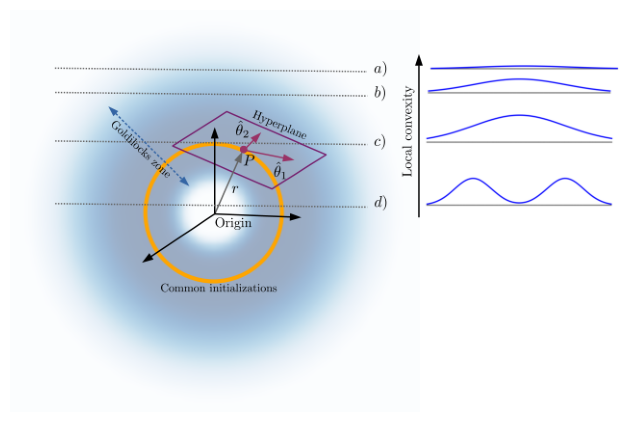

In [6]:
#@title Figure 1 form [1] : the Goldilocks zone representation
pdf_path = f'{input_path}/Figures [1]/koule_s_vlnkami-eps-converted-to.pdf'

pdf_document = fitz.open(pdf_path)
page = pdf_document.load_page(0)
pix = page.get_pixmap()
img = Image.open(io.BytesIO(pix.tobytes("png")))  # Convertir en image PIL
pdf_document.close()

plt.imshow(img)
plt.axis('off')  # Cacher les axes

plt.tight_layout()
plt.show()

## **Initialization on a Thin Spherical Shell**  

To illustrate this first phenomenon, we initialize a weight vector of dimension \( 200,000 \) using the Xavier and Kaiming initialization methods.  
We then compute the L2 norm of this vector.  

Repeating this process 100 times, we visualize the distribution of the resulting norms.  

The required functions are primarily found in `geometry_experiments.py`.  

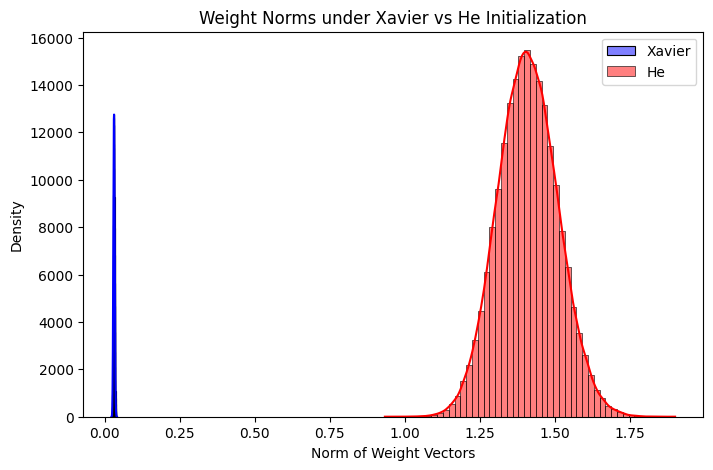

In [7]:
plot_distribution_norms_init((200_000, 100))

The distribution shows that the norm of the weight vectors is highly concentrated for both Xavier and Kaiming initialization. This indicates that all vectors lie at approximately the same radius in the latent space.

Comparing the variance of the spherical shell, we observe that vectors initialized with Xavier are significantly more concentrated around this shell than those initialized with Kaiming.

## **The *Tangency* Initialization**  

The authors of [1] state that a \( d \)-dimensional hyperplane is more likely to be tangent to a \( D \)-dimensional hypersphere when \( d << D \).  

To illustrate this, consider a point \((x_b, y_b)\) in a 2D space. The circle centered at the origin passing through this point is tangent to a line parameterized by:  
\[
(x, y) = (x_a, y_a) •
t + (x_b, y_b)
\]


if and only if the dot product satisfies:  
\[
(x_a, y_a) •
(x_b, y_b) = 0.
\]

The **cosine similarity** measures the alignment between vectors:  
- A value of **1** indicates no tangency at all.  
- A value of **0** means the line is exactly tangent to the circle at the given point.  



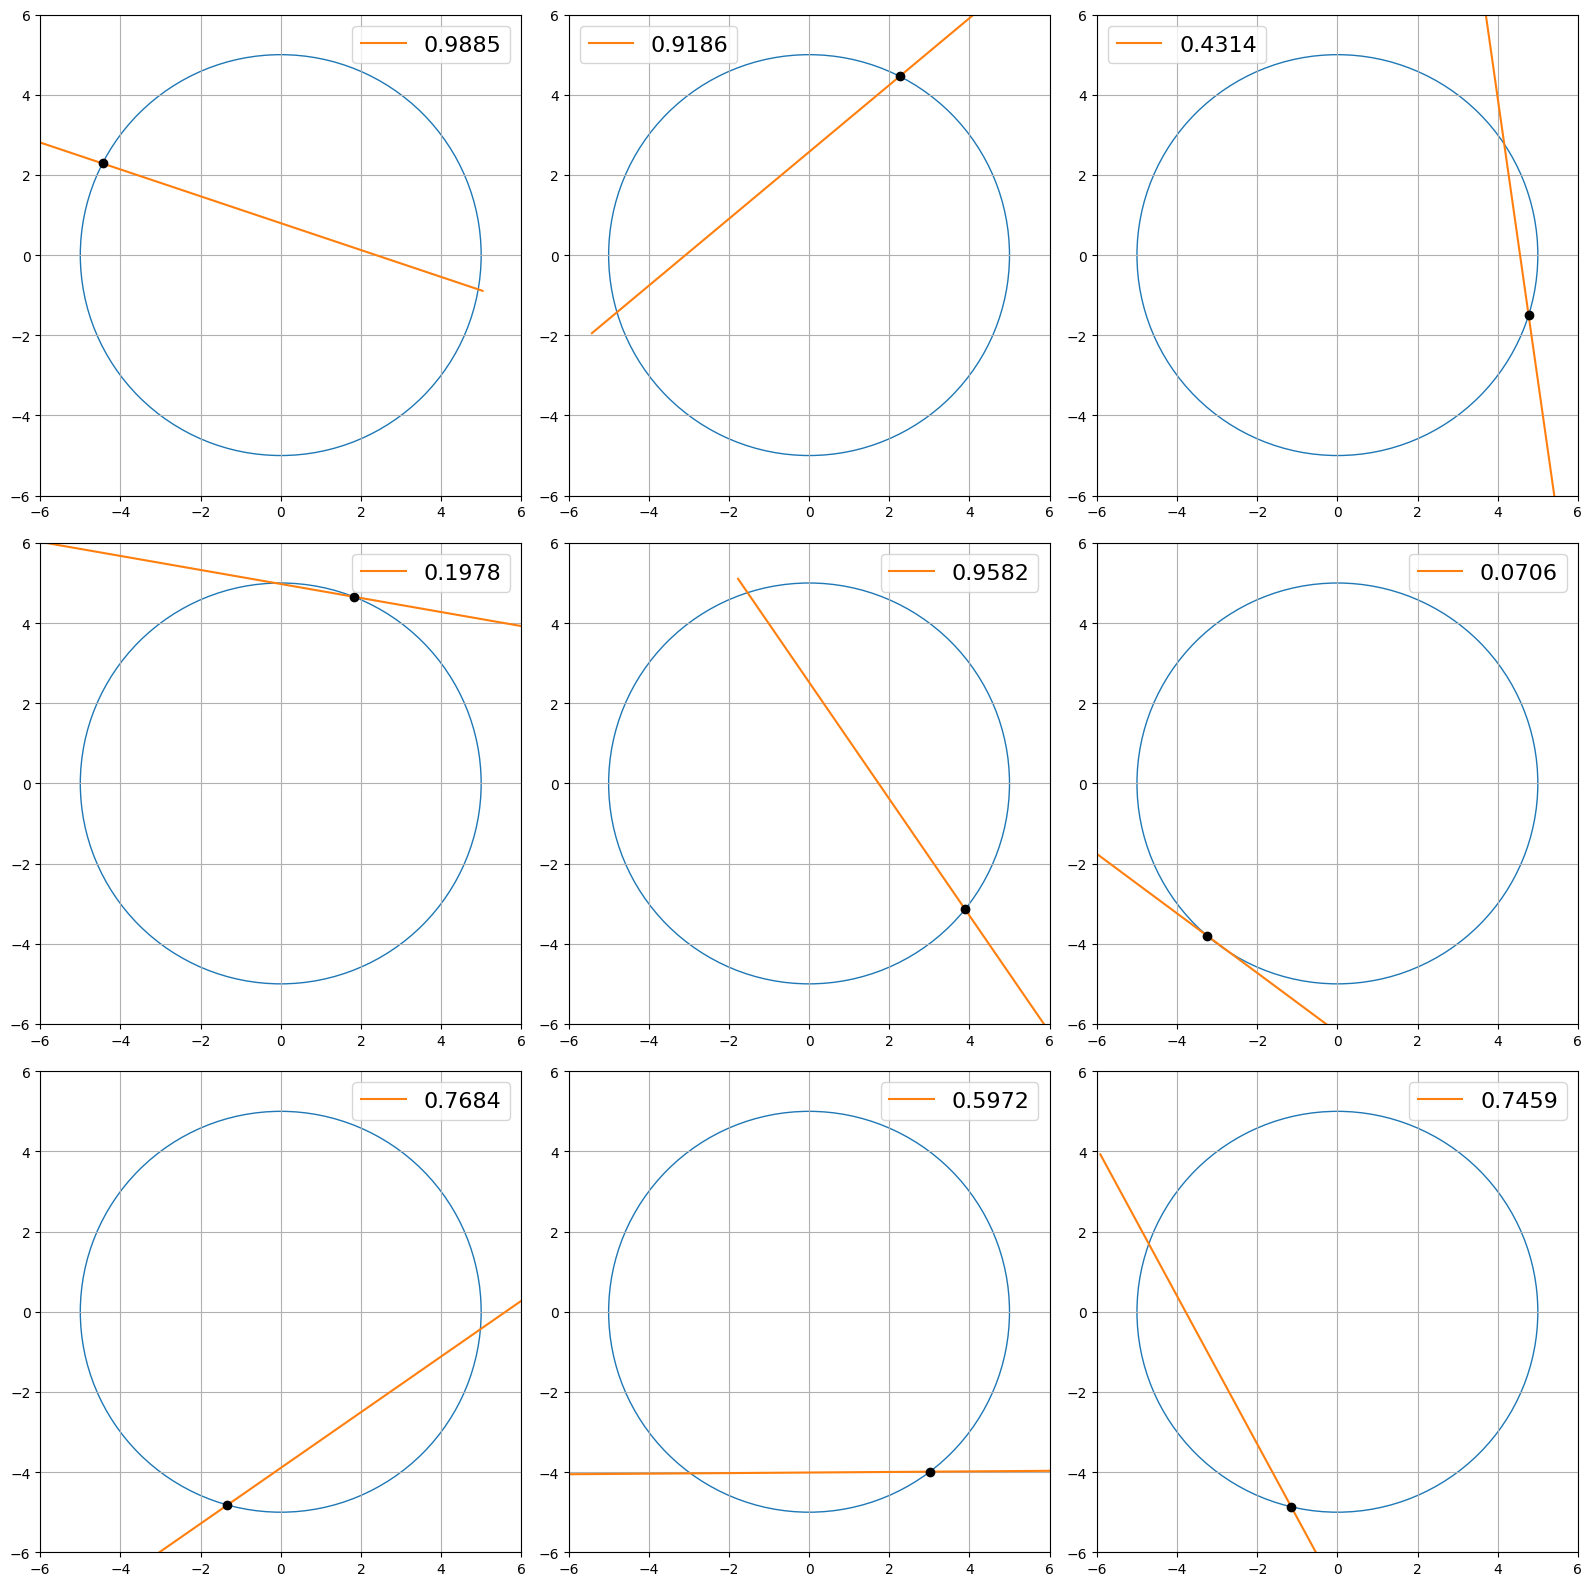

In [8]:
visualization_1(D=2, d=1)

From the plot, we observe that the lower the tangency metric score, the better the line aligns as a tangent to the circle. When the score approaches zero, the line nearly perfectly touches the circle at a single point, confirming the expected theoretical behavior. Conversely, higher scores indicate a greater deviation from tangency, meaning the line increasingly intersects the circle rather than just touching it.

### **Extending to Higher Dimensions**  

For a **2D plane in a 3D space**, we need:  
- A **\(3 *x* 2\)** matrix representing the plane.  
- A **\(3 *x* 1\)** vector representing the point on the sphere.  

The plane is **tangent to the sphere** if the dot product between each column of the matrix and the point is zero.  

To measure tangency in higher dimensions, we:  
1. Compute the **cosine similarity** between each column of the hyperplane matrix and the starting point.  
2. Calculate the **L2 norm** of the cosine similarity vector, which represents the deviation from perfect tangency (i.e., the zero vector).   

/content/goldilocks-zone-main/utils.py:98: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at ../aten/src/ATen/native/Cross.cpp:62.)
  normal_vector = torch.cross(M[:, 0], M[:, 1])


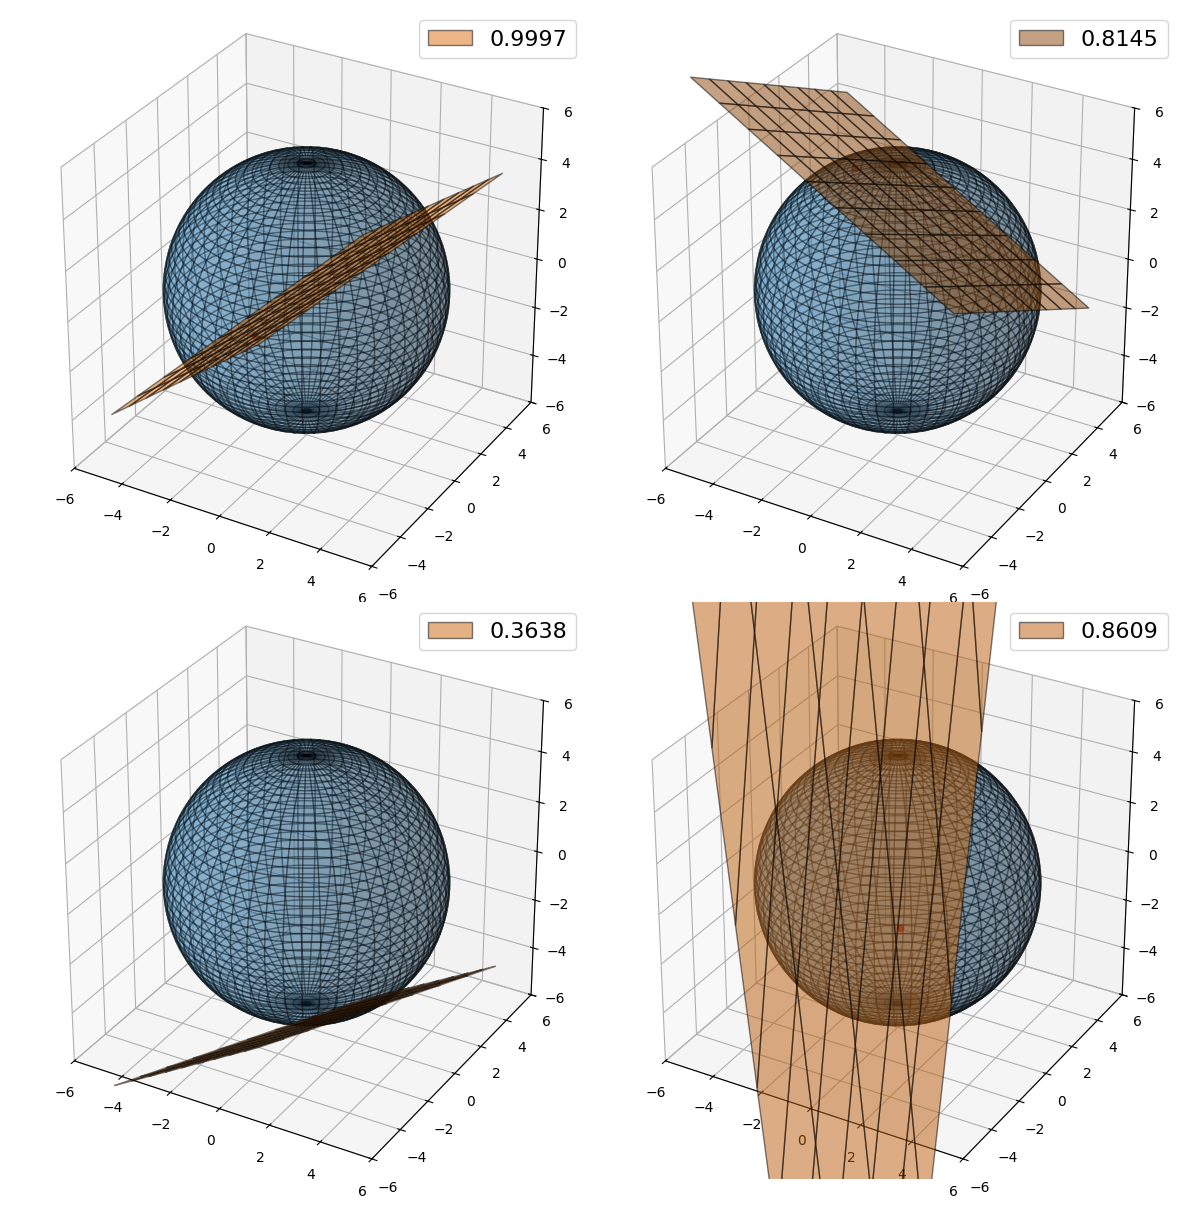

In [9]:
visualization_1(D=3, d=2)

In the case of a 2D plane within a 3D space, the tangency metric behaves similarly to the 2D case but is less visually intuitive. A lower tangency score still indicates better alignment, meaning the plane is closer to being tangent to the sphere at a single contact curve rather than intersecting it. Conversely, higher scores correspond to greater deviations, where the plane cuts through the sphere instead of just touching it.

While harder to visualize directly, the metric remains a useful quantitative measure of tangency in higher dimensions. The trend observed in 2D generalizes: the lower the tangency metric, the closer the plane is to being perfectly tangent to the sphere.

### **Generalizing to High-Dimensional Spaces**  

Now, let’s observe the effect of this tangency metric in high-dimensional spaces, where the hyperplane has significantly fewer dimensions than the ambient space.

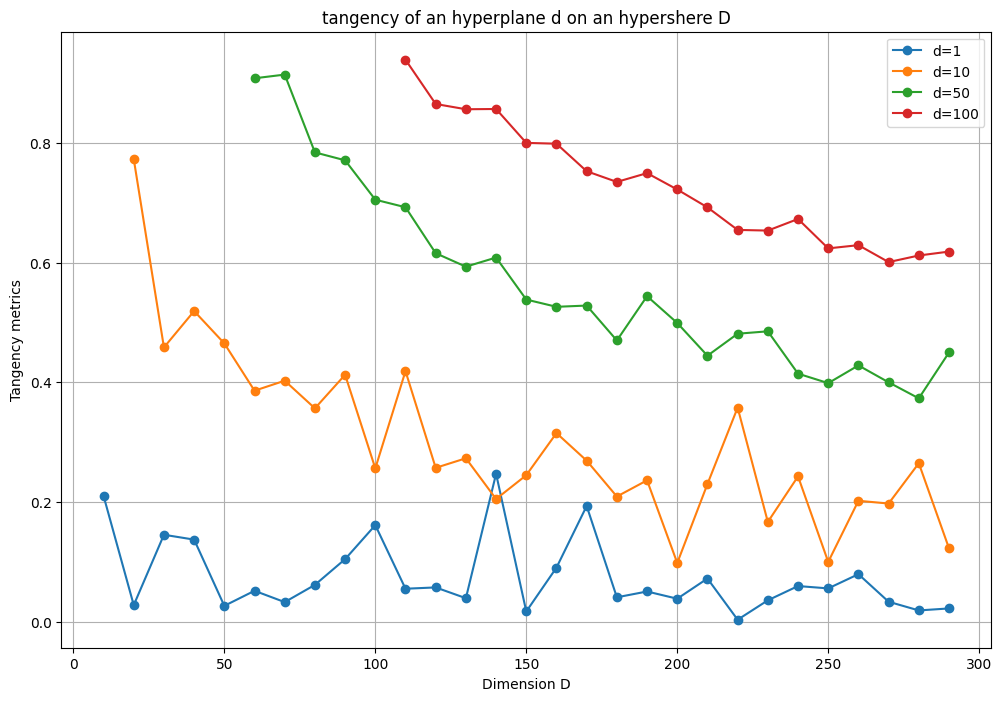

In [10]:
visualization_2()

From the figure, we observe a clear trend: as the dimension \( D \) increases, the tangency metric systematically decreases for all values of \( d \) (1, 10, 50, 100). This indicates that higher-dimensional hyperplanes become increasingly tangent to the hypersphere.  

This result aligns with theoretical expectations: in high-dimensional spaces, randomly chosen hyperplanes are more likely to be nearly orthogonal to the radial direction of the sphere. As a consequence, they tend to align more closely with its surface, reinforcing the intuition that in the limit \( D -> +ထ
 \), hyperplanes behave almost like local tangents.  

---
# Experimentation preparation: Exploring the Goldilocks Zone
Now that we have established key geometric intuitions, we move on to a series of experiments aimed at visualizing and understanding the Goldilocks Zone in neural network initialization. In the following sections, we will reproduce three core experiments from [1], each designed to highlight different aspects of the loss landscape and its sensitivity to initialization. These experiments will provide empirical evidence allowing us to better grasp the role of initialization in neural network optimization.

These experiments are conducted on the MNIST dataset using a fully connected neural network with architecture [28×28, 200, 200, 10] with a ReLU non-linearity. The weights are initialized with Xavier initialization, but with an additional scaling parameter *l* that controls how far the initialization deviates from the standard Xavier norm. Specifically, after initializing the weights with Xavier, we rescale them so that their norm matches the radius desired. This allows us to systematically study the effect of varying the initialization radius on the network's training dynamics and loss landscape.


To analyze the impact of initialization, we restrict our search to a **low-dimensional subspace** within the full weight space. This is done using a **randomly generated orthogonal basis** that defines a hyperplane:  

- The model parameters are represented in a reduced coordinate system \( \theta \), projected using an orthonormal matrix \( M \) of size \( D \times d \).  
- The optimizer updates the parameters within this subspace, ensuring that all weight updates remain constrained to this lower-dimensional region.  
- The gradient of the loss is projected into the subspace, ensuring that updates follow the reduced coordinates while capturing relevant curvature information.


The Hessian matrix is estimated using **finite differences** in a lower-dimensional projected space, following approaches inspired by [3,4]. Given a neural network with parameters \(\theta\), we compute the Hessian \( H \) using the following steps:  

1. **Compute the base gradient:** The gradient of the loss function is calculated at the current point in parameter space.  
2. **Finite difference approximation:** The network parameters are perturbed along each basis direction of the subspace, and the gradient is recomputed. The difference between perturbed and base gradients provides an estimate of the Hessian column.  
3. **Ensure symmetry and numerical stability:** The Hessian matrix is symmetrized to reduce numerical errors, and a small diagonal term is added to improve stability.  

By performing this computation in a **reduced space** of dimension \( d \), rather than in the full parameter space of dimension \( D \), we obtain an efficient approximation of the Hessian structure that retains essential curvature information.  



This setup allows us to efficiently study how the **Hessian spectrum** and **curvature properties** evolve as a function of initialization radius, without having to optimize in the full-dimensional parameter space.

In [11]:
#@title Import data from MNIST thanks to MnistDataloader

class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

training_images_filepath = join(input_path, 'data/train-images.idx3-ubyte')
training_labels_filepath = join(input_path, 'data/train-labels.idx1-ubyte')
test_images_filepath = join(input_path, 'data/t10k-images.idx3-ubyte')
test_labels_filepath = join(input_path, 'data/t10k-labels.idx1-ubyte')

mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

# Convert to PyTorch tensors
x_train = torch.tensor(np.array(x_train), dtype=torch.float32).to(device)
y_train = torch.tensor(np.array(y_train), dtype=torch.long).to(device)
x_test = torch.tensor(np.array(x_test), dtype=torch.float32).to(device)
y_test = torch.tensor(np.array(y_test), dtype=torch.long).to(device)

print("Data imported successfully : ")
print("x_train shape : ",x_train.shape) #torch.Size([60000, 28, 28])
print("y_train shape : ",y_train.shape) #torch.Size([60000])
print("x_test shape : ",x_test.shape) #torch.Size([10000, 28, 28])
print("y_test shape : ",y_test.shape) #torch.Size([10000])

Data imported successfully : 
x_train shape :  torch.Size([60000, 28, 28])
y_train shape :  torch.Size([60000])
x_test shape :  torch.Size([10000, 28, 28])
y_test shape :  torch.Size([10000])


In [12]:
#@title Neural Network Model

class ScaledNN(nn.Module):
    def __init__(self, layer_sizes, l):
        """
        Args:
            layer_sizes (list): List of integers representing the number of neurons per layer.
            l (float): Parameter to determine how far from xavier initialization we want to be.
            xavier initialisation of the weights scaling to the norm of the weight vector to be r
        """
        super(ScaledNN, self).__init__()

        self.layers = nn.ModuleList()
        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))

        # Compute total number of parameters (D)
        D = sum(p.numel() for p in self.parameters() if p.requires_grad)

        if D <= 1:
            raise ValueError("D must be greater than 1 for proper initialization.")

        # Xavier initialization
        xavier_init = torch.nn.init.xavier_normal_
        for layer in self.layers:
            xavier_init(layer.weight)
            nn.init.zeros_(layer.bias)  # Initialize biases to 0

        # Compute current norm after Xavier initialization
        all_weights = torch.cat([layer.weight.view(-1) for layer in self.layers])
        current_norm = torch.norm(all_weights)

        # Compute target radius (same as in original class)
        target_radius = current_norm * np.power(10, l/2)

        # Calculate scaling factor
        scaling_factor = target_radius / current_norm

        # Scale weights to achieve exact target radius
        with torch.no_grad():
            for layer in self.layers:
                layer.weight.mul_(scaling_factor)

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        return self.layers[-1](x)  # No activation on last layer

In [13]:
#@title Functions to compute and analyse the hessian in the reduced space

def compute_hessian(model, hyperplane_opt, criterion, x_train, y_train, eps=1e-6):
    """
    Compute the Hessian matrix in the reduced space using finite differences.
    Based on the approach from:
    - "Hessian-based Analysis of Large Batch Training and Robustness to Adversaries" (Yao et al., 2018) [3]
    - "ADAHESSIAN: An Adaptive Second Order Optimizer for Machine Learning" (Yao et al., 2020) [4]

    Args:
        model: Neural network model
        hyperplane_opt: HyperplaneOptimizer instance
        criterion: Loss function
        x_train: Input data
        y_train: Target data
        eps: Small perturbation for finite differences (default: 1e-6)

    Returns:
        torch.Tensor: d x d Hessian matrix in the reduced space
    """
    d = hyperplane_opt.d

    hessian = torch.zeros(d, d).to(device)

    # Store original parameters
    original_theta = hyperplane_opt.theta.data.clone()

    # Compute gradient at current point
    model.zero_grad()
    outputs = model(x_train.view(-1, 28*28))
    loss = criterion(outputs, y_train)
    loss.backward()



    # Get projected gradient
    full_grad = torch.cat([p.grad.view(-1) for p in model.parameters()])
    base_grad = hyperplane_opt.project_gradient(full_grad)

    # Compute Hessian using finite differences on projected space
    for i in range(d):
        # Perturb in direction i
        perturbation = torch.zeros(d).to(device)
        perturbation[i] = eps
        hyperplane_opt.theta.data = original_theta + perturbation
        # Update model parameters
        hyperplane_opt.update_model_params(model)

        # Forward and backward pass for perturbed position
        model.zero_grad()
        outputs = model(x_train.view(-1, 28*28))
        loss = criterion(outputs, y_train)
        loss.backward()

        # Get projected gradient at perturbed position
        full_grad_perturbed = torch.cat([p.grad.view(-1) for p in model.parameters()])
        perturbed_grad = hyperplane_opt.project_gradient(full_grad_perturbed)

        # Finite difference approximation of Hessian column
        hessian[:, i] = (perturbed_grad - base_grad) / eps

        # Restore original parameters
        hyperplane_opt.theta.data = original_theta.clone()
        hyperplane_opt.update_model_params(model)

    # Ensure symmetry (due to numerical errors)
    hessian = (hessian + hessian.t()) / 2
    # Add small diagonal term for numerical stability
    hessian.add_(torch.eye(d).to(device) * 1e-6)

    return hessian

def analyze_hessian(hessian):
    """
    Analyze the Hessian properties
    """
    eigenvalues, eigenvectors = torch.linalg.eigh(hessian)

    # Basic statistics
    condition_number = abs(eigenvalues[-1] / (eigenvalues[0] + 1e-10))
    positive_curvature = (eigenvalues > 0).sum().item()
    negative_curvature = (eigenvalues < 0).sum().item()

    results = {
        'eigenvalues': eigenvalues,
        'eigenvectors': eigenvectors,
        'condition_number': condition_number,
        'positive_curvature_dims': positive_curvature,
        'negative_curvature_dims': negative_curvature,
        'max_eigenvalue': eigenvalues.max().item(),
        'min_eigenvalue': eigenvalues.min().item(),
        'trace': eigenvalues.sum().item()
    }

    return results


def analyze_convexity(model, hyperplane_opt, criterion, x_train, y_train, d):
    """
    Analyze convexity properties at a specific radius

    Args:
        model: Neural network model
        hyperplane_opt: Hyperplane optimizer
        criterion: Loss function
        x_train: Input data
        y_train: Target data
        radius: Radius relative to initialization variance
        initial_var: Initial variance (r²_xavier)
        d: Dimension of hyperplane

    Returns:
        Dictionary of convexity measures
    """

    # Compute loss at this point
    model.zero_grad()
    outputs = model(x_train.view(-1, 28*28))
    loss = criterion(outputs, y_train)

    # Compute Hessian of loss w.r.t. hyperplane parameters
    hessian = compute_hessian(model, hyperplane_opt, criterion, x_train, y_train)

    # Analyze Hessian
    analysis = analyze_hessian(hessian)
    return {
        'pos_fraction': analysis['positive_curvature_dims'] / d,
        'trace_norm_ratio': analysis['trace'] / torch.sqrt(torch.sum(analysis['eigenvalues'] ** 2)).cpu().item(),
        'condition_number': analysis['condition_number'].cpu().item(),
        'max_eigenvalue': analysis['max_eigenvalue'],
        'min_eigenvalue': analysis['min_eigenvalue']
    }

In [14]:
#@title Hyperplane definition

def generate_orthogonal_matrix(D, d, device='cpu'):
    """
    Génère une matrice orthogonale M de taille D x d en utilisant QR decomposition.
    """
    M = torch.randn(D, d, device=device)  # Generate random matrix on the specified device
    Q, R = torch.linalg.qr(M)  # Perform QR decomposition
    return Q[:, :d]  # Return the first d columns of Q

class HyperplaneOptimizer(nn.Module):  # Inherit from nn.Module
    def __init__(self, model, D, d, device='cpu'):
        super(HyperplaneOptimizer, self).__init__()  # Initialize nn.Module
        self.D = D
        self.d = d
        self.device = device

        # Point initial dans l'espace complet
        self.P = nn.Parameter(torch.zeros(D, device=device))

        # Génère une base orthonormée pour le sous-espace
        self.M = generate_orthogonal_matrix(D, d, device=device)

        # Coordonnées dans le sous-espace
        self.theta = nn.Parameter(torch.zeros(d, device=device))

        # Sauvegarde les paramètres initiaux du modèle
        self.initial_params = torch.cat([p.data.view(-1) for p in model.parameters()]).to(device)
        self.P.data.copy_(self.initial_params)

    def project_gradient(self, grad):
        """
        Projette le gradient dans le sous-espace défini par M
        """
        return self.M.T @ grad

    def get_params(self):
        """
        Obtient les paramètres dans l'espace complet
        """
        return self.P + self.M @ self.theta

    def update_model_params(self, model):
        """
        Met à jour les paramètres du modèle
        """
        params = self.get_params()
        idx = 0
        for p in model.parameters():
            p_size = p.numel()
            p.data.copy_(params[idx:idx + p_size].view(p.size()))
            idx += p_size

In [15]:
#@title Defining Base Experiment Parameters

@dataclass
class BaseExperimentArgs:
    """
    Base class for experiment parameters
    """
    model_class: type = ScaledNN
    hyperplane_opt_class: type = HyperplaneOptimizer
    criterion: nn.Module = nn.CrossEntropyLoss()
    layer_sizes: list = field(default_factory=lambda: [28*28, 200, 200, 10])

---
# First experiment : *Curvature statistics - the Goldilocks zone in focus*

In this experiment, we aim to analyze how the **positive curvature fraction** evolves as we rescale the initialization radius. Additionally, we investigate the behavior of the **trace-to-norm ratio of the Hessian** (\(Tr(H) / ||H||\)), a key metric introduced in [1] to quantify curvature properties.  

Our goal is to reproduce the results from **Figure 3 in [1]**, where the authors demonstrate that the Goldilocks Zone corresponds to a region where the positive curvature fraction and the (\(Tr(H) / ||H||\)) metric are maximized. By systematically varying the initialization radius and measuring these curvature properties, we compare our findings with those reported in the original paper to validate the Goldilocks Zone phenomenon.

In [16]:
#@title Setting experiment parameters

#The default parameters were used to plot the experiments.
#Changing these parameters may cause disturbances in the results.
#For each run, the script adds the results to the old file.
#This is done to save the results without having to do it all at once.
#If you want to change anything other than num_trials and dimensions
#you must change the path of the save_dir file.

# Expérience 1 : Curvature statistics: the Goldilocks zone in focus
@dataclass
class CurvatureGoldilocksFocusExperimentArgs(BaseExperimentArgs):
    num_points: int = 50
    num_trials: int = 10
    dimensions: list = field(default_factory=lambda: [10, 50, 100])
    log_scales: np.ndarray = field(default_factory=lambda: np.linspace(-4, 4, 50))
    save_dir: str = f"{input_path}/results/Curvature statistics_ the Goldilocks zone in focus"
    metrics: dict = field(default_factory=lambda: {
        'pos_fraction': 'Positive Eigenvalue Fraction',
        'trace_norm_ratio': 'Tr(H)/||H||',
        'condition_number': 'Condition Number',
        'max_eigenvalue': 'Max Eigenvalue',
    })

    def validate(self):
        """ Ensure consistency of experiment settings """
        default_save_dir = f"{input_path}/results/Curvature statistics_ the Goldilocks zone in focus"
        if self.save_dir == default_save_dir and (
            self.log_scales.tolist() != np.linspace(-4, 4, self.num_points).tolist()
            or self.num_points != 50
            or self.model_class != ScaledNN
            or self.hyperplane_opt_class != HyperplaneOptimizer
            or not isinstance(self.criterion, nn.CrossEntropyLoss)
            or self.layer_sizes != [28*28, 200, 200, 10]
            or self.metrics != {
                'pos_fraction': 'Positive Eigenvalue Fraction',
                'trace_norm_ratio': 'Tr(H)/||H||',
                'condition_number': 'Condition Number',
                'max_eigenvalue': 'Max Eigenvalue',
            }
        ):
            raise ValueError("For further experiments, please change the `save_dir` path.")


args = CurvatureGoldilocksFocusExperimentArgs()
args.validate()  # Ensure settings are consistent

for arg in args.__dict__:
    print(f"{arg}: {getattr(args, arg)}")

model_class: <class '__main__.ScaledNN'>
hyperplane_opt_class: <class '__main__.HyperplaneOptimizer'>
criterion: CrossEntropyLoss()
layer_sizes: [784, 200, 200, 10]
num_points: 50
num_trials: 10
dimensions: [10, 50, 100]
log_scales: [-4.         -3.83673469 -3.67346939 -3.51020408 -3.34693878 -3.18367347
 -3.02040816 -2.85714286 -2.69387755 -2.53061224 -2.36734694 -2.20408163
 -2.04081633 -1.87755102 -1.71428571 -1.55102041 -1.3877551  -1.2244898
 -1.06122449 -0.89795918 -0.73469388 -0.57142857 -0.40816327 -0.24489796
 -0.08163265  0.08163265  0.24489796  0.40816327  0.57142857  0.73469388
  0.89795918  1.06122449  1.2244898   1.3877551   1.55102041  1.71428571
  1.87755102  2.04081633  2.20408163  2.36734694  2.53061224  2.69387755
  2.85714286  3.02040816  3.18367347  3.34693878  3.51020408  3.67346939
  3.83673469  4.        ]
save_dir: /content/gdrive/MyDrive/Polytechnique Mtl/Deep learning dynamics/The goldilocks zone /results/Curvature statistics_ the Goldilocks zone in focus
met

In [17]:
#@title plotting function experiment the *goldilocks_zone_focus*

def plot_goldilocks_zone_focus(total_trials, selected_metrics, args):
    num_metrics = len(selected_metrics)

    # Dynamically define rows and columns for subplots
    num_cols = 2  # Fixing to 2 columns for better visualization
    num_rows = math.ceil(num_metrics / num_cols)  # Calculate needed rows

    colors = {10 : "blue", 50 : "green", 100 : "red"}

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

    # Flatten axs if it's a 2D array (needed for iteration)
    axs = np.array(axs).flatten()

    for idx, (metric_name) in enumerate(selected_metrics):
        ax = axs[idx]
        metric_title = args.metrics[metric_name]

        for dim_idx, d in enumerate(args.dimensions):

            trial_results = total_trials[dim_idx]

            mean_metric_values = np.mean(trial_results[metric_name], axis=0)
            std_metric_values = np.std(trial_results[metric_name], axis=0)

            if d in colors.keys():
                color = colors[d]
                ax.plot(args.log_scales, mean_metric_values, label=f'd = {d}', color = color)
                ax.fill_between(args.log_scales,
                            mean_metric_values - std_metric_values,
                            mean_metric_values + std_metric_values,
                            color = color,
                            alpha=0.2)

            else:
                ax.plot(args.log_scales, mean_metric_values, label=f'd = {d}')
                ax.fill_between(args.log_scales,
                            mean_metric_values - std_metric_values,
                            mean_metric_values + std_metric_values,
                            alpha=0.2)



        ax.set_xlabel(r'$\log_{10}(r^2/r^2_{xavier})$')
        ax.set_ylabel(metric_title)
        ax.set_title(metric_title)
        ax.legend()
        ax.grid(True, linestyle=':')

        # Vertical line for Xavier initialization
        ax.axvline(x=0, color='r', linestyle='--', alpha=0.5)

    # Remove unused subplots if any
    for idx in range(num_metrics, len(axs)):
        fig.delaxes(axs[idx])

    plt.tight_layout()
    plt.show()

In [18]:
#@title Exeriment's function : save results in save_dir
def goldilocks_zone_focus(model_class, layer_sizes, hyperplane_opt_class, criterion, x_train, y_train,metrics,
                                  dimensions=[10, 50, 100], num_points=50, num_trials=5, save_dir="results_test",
                                  log_scales = np.linspace(-4, 4, 50)):
    """
    Args:
        model_class: Neural network model class (not instance)
        layer_sizes: List of layer sizes for the model
        hyperplane_opt_class: Hyperplane optimizer class (not instance)
        criterion: Loss function
        x_train: Input data
        y_train: Target data
        dimensions: List of hyperplane dimensions to analyze
        num_points: Number of points to evaluate along the log scale
        num_trials: Number of trials to average over for each dimension
        save_dir: Directory path to save results
        log_scales: Array of log scales to evaluate
    """
    os.makedirs(save_dir, exist_ok=True)  # Ensure directory exists

    D = compute_total_parameters(layer_sizes)
    log_scales = np.linspace(-4, 4, num_points)

    for d in dimensions:
        trial_results = {metric_name: [] for metric_name in metrics}
        trial_file = os.path.join(save_dir, f"result_trials_{d}.pkl")

        # Load existing trials if they exist
        if os.path.exists(trial_file):
            with open(trial_file, "rb") as f:
                trial_results = pickle.load(f)

        for trial in range(num_trials):
            results = []
            for l in tqdm(log_scales, desc=f'Dimension {d}, Trial {trial + 1}'):
                model = model_class(layer_sizes, l).to(device)
                hyperplane_opt = hyperplane_opt_class(model, D, d, device)
                result = analyze_convexity(model, hyperplane_opt, criterion, x_train, y_train, d)
                results.append(result)

            for metric_name in metrics:
                trial_results[metric_name].append([r[metric_name] for r in results])

            # Save updated trials after each trial
            with open(trial_file, "wb") as f:
                pickle.dump(trial_results, f)

    return

In [ ]:
#@title Call of the experiement's function
goldilocks_zone_focus(
    model_class=args.model_class,
    layer_sizes=args.layer_sizes,
    hyperplane_opt_class=args.hyperplane_opt_class,
    criterion=args.criterion,
    x_train=x_train,
    y_train=y_train,
    dimensions=args.dimensions,
    num_points=args.num_points,
    num_trials=args.num_trials,
    log_scales=args.log_scales,
    save_dir=args.save_dir,
    metrics=args.metrics
)

Dimension 100, Trial 1: 100%|██████████| 50/50 [01:56<00:00,  2.32s/it]


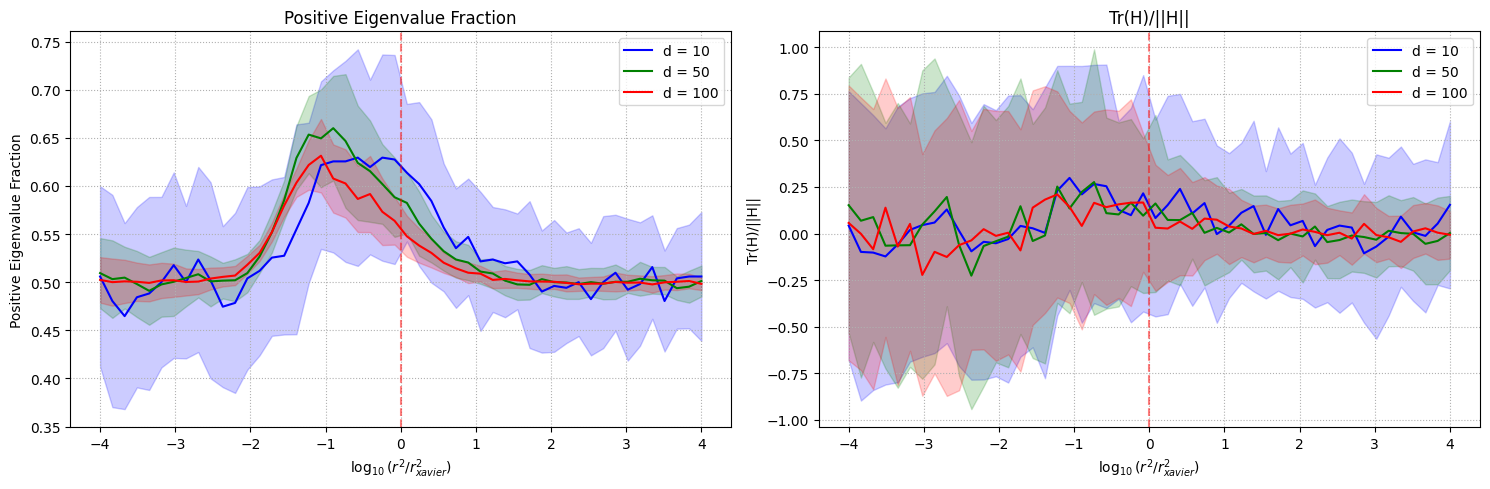

In [19]:
#@title View results from the saved file

# Load trial results
total_trials = []
for d in args.dimensions:
    path_result = f"{args.save_dir}/result_trials_{d}.pkl"

    with open(path_result, "rb") as f:
        result = pickle.load(f)

    total_trials.append(result)

# Define the metrics to plot

# Choose metrics to plot
selected_metrics = ['pos_fraction', 'trace_norm_ratio']  # Modify as needed
#'condition_number','max_eigenvalue'


# Call the function with selected metrics
plot_goldilocks_zone_focus(total_trials, selected_metrics, args)

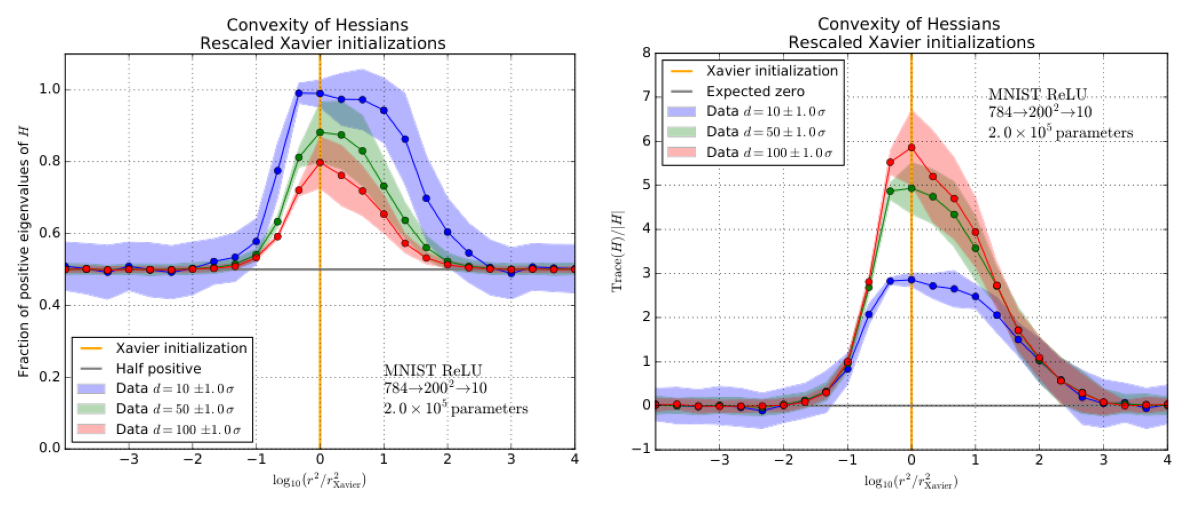

In [20]:
#@title Comparaison with paper's [1] figures
pdf_paths = [
    f'{input_path}/Figures [1]/metric_radii_sweep_xavier2_frac.pdf',
    f'{input_path}/Figures [1]/metric_radii_sweep_xavier2_evalssum2.pdf'
]

# Charger les images des deux fichiers PDF
images = []
for pdf_path in pdf_paths:
    pdf_document = fitz.open(pdf_path)
    page = pdf_document.load_page(0)  # On suppose une seule page par fichier
    pix = page.get_pixmap()
    img = Image.open(io.BytesIO(pix.tobytes("png")))  # Convertir en image PIL
    images.append(np.array(img))  # Convertir en tableau numpy pour plt.imshow
    pdf_document.close()

# Afficher les images côte à côte
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for ax, img, title in zip(axes, images, ["Metric Radii Sweep (Frac)", "Metric Radii Sweep (EvalSum2)"]):
    ax.imshow(img)
    #ax.set_title(title)
    ax.axis('off')  # Cacher les axes

plt.tight_layout()
plt.show()

#### **Observations**

Now that we have obtained our results, we compare them with the findings from **Figure 3 in [1]**.  

- **Positive Curvature Fraction Plot:**  
  We observe the existence of the **Goldilocks Zone**, characterized by a peak in the positive curvature fraction. However, in our results, this peak appears **slightly before** the one reported in the paper. Additionally, as noted in [1], when the dimensionality \( d \) increases, the peak of the positive curvature fraction becomes **less defined**, which we also observe in our plots.  

- **Trace-to-Norm Ratio Plot (\(\text{Tr}(H) / \|H\|\)):**  
  Unlike in the paper, our results exhibit **high variance**, making it more challenging to clearly identify the trends. While a slight peak is visible, it is **less pronounced** compared to the one presented in [1]. Moreover, distinguishing between the curves corresponding to different values of \( d \) (10, 50, 100) is difficult due to overlapping trends.  

- **General Observation:**  
  Across both plots, we notice that our results display **more variance** compared to the original paper, which might be due to differences in the experimental setup or computational precision. Despite these discrepancies, the general shape of the curves aligns with the expected behavior, reinforcing the presence of the Goldilocks Zone phenomenon.

---
# Second experiment : *Loss initialisation and positive curvature correlation*

In this experiment, we analyze the relationship between the **loss at initialization** and the **fraction of positive curvature directions**. Our goal is to investigate whether a strong correlation exists between these two quantities, as suggested in [1].  

To do this, we:  
1. Compute the **initial loss** of the network using the cross-entropy criterion.  
2. Estimate the **fraction of positive curvature directions** by computing the Hessian and counting its positive eigenvalues.  
3. Compare our results to those presented in the reference paper.  



In [21]:
#@title Setting experiment parameters

@dataclass
class LossPositiveCorellationExperimentArgs(BaseExperimentArgs):
    num_points: int = 200
    save_dir: str = f"{input_path}/results/Initial loss and positive curvatures  correlation"
    dimension : int = 200 #dimension of the hyperplane
    xavier_distance : int = 0 #distance from xavier initialisation


    def validate(self):
        """ Ensure consistency of experiment settings """
        default_save_dir = f"{input_path}/results/Initial loss and positive curvatures  correlation"
        if self.save_dir == default_save_dir and (
            self.model_class != ScaledNN
            or self.hyperplane_opt_class != HyperplaneOptimizer
            or not isinstance(self.criterion, nn.CrossEntropyLoss)
            or self.layer_sizes != [28*28, 200, 200, 10]
            or self.dimension != 200
            or self.xavier_distance != 0
        ):
            raise ValueError("For further experiments, please change the `save_dir` path.")

args = LossPositiveCorellationExperimentArgs()
args.validate()  # Ensure settings are consistent

for arg in args.__dict__:
    print(f"{arg}: {getattr(args, arg)}")

model_class: <class '__main__.ScaledNN'>
hyperplane_opt_class: <class '__main__.HyperplaneOptimizer'>
criterion: CrossEntropyLoss()
layer_sizes: [784, 200, 200, 10]
num_points: 200
save_dir: /content/gdrive/MyDrive/Polytechnique Mtl/Deep learning dynamics/The goldilocks zone /results/Initial loss and positive curvatures  correlation
dimension: 200
xavier_distance: 0


In [22]:
#@title Plotting function experiment *loss_positive_correlation*

def plot_loss_positive_correlation(pos_eigenvalues_list, loss_list):
    plt.figure(figsize=(10, 6))

    # Calcul de l'interpolation linéaire
    coeffs = np.polyfit(pos_eigenvalues_list, loss_list, 1)
    poly = np.poly1d(coeffs)
    x_fit = np.linspace(min(pos_eigenvalues_list), max(pos_eigenvalues_list), 100)
    y_fit = poly(x_fit)

    # Calcul de l'écart-type (sigma)
    residuals = np.array(loss_list) - poly(np.array(pos_eigenvalues_list))
    sigma = np.std(residuals)

    # Traçage des données
    plt.scatter(pos_eigenvalues_list, loss_list, color='blue', alpha=0.5, label='Data')
    plt.plot(x_fit, y_fit, color='blue', label='Best linear fit ±1σ')

    # Remplissage à plus ou moins un sigma
    plt.fill_between(x_fit, y_fit - sigma, y_fit + sigma, color='blue', alpha=0.2)

    plt.title('Characteristics of initial points on hyperplanes')
    plt.xlabel('Number of positive eigenvalues of Hessian on hyperplane')
    plt.ylabel('Loss at initialization')
    plt.legend()
    plt.grid(True)
    plt.show()

In [23]:
#@title Experiment's function : save results in save_dir
def loss_positive_correlation(model_class, criterion, layer_sizes, num_points, hyperplane_opt_class,
                                  x_train, y_train, save_dir,xavier_distance, dimension,
                              ):

    # Load existing trials if they exist
    data_path = os.path.join(save_dir, 'data.pkl')
    if os.path.exists(data_path):
        with open(data_path, "rb") as f:
            data = pickle.load(f)
    else :
        data = {
            'pos_eigenvalues_list': [],
            'loss_list': []
        }
    pos_eigenvalues_list = []
    loss_list = []

    for i in tqdm(range(num_points)):
        # Initialisation du modèle et des optimiseurs
        model = model_class(layer_sizes, xavier_distance).to(device)
        criterion = criterion

        D = sum(p.numel() for p in model.parameters())
        hyperplane_opt = HyperplaneOptimizer(model, D, dimension, device)
        hess = compute_hessian(model, hyperplane_opt, criterion, x_train, y_train)
        analyse = analyze_hessian(hess)

        pos_eigenvalues = (analyse['eigenvalues'] > 0).sum().item()
        loss = criterion(model(x_train.view(-1, 28*28)), y_train).item()

        pos_eigenvalues_list.append(pos_eigenvalues)
        loss_list.append(loss)

        data['pos_eigenvalues_list'].append(pos_eigenvalues)
        data['loss_list'].append(loss)

        if i % 10 == 0:
          pickle_file_path = os.path.join(save_dir, 'data.pkl')
          with open(pickle_file_path, 'wb') as file:
              pickle.dump(data, file)

In [ ]:
#@title Call the experiment's function
loss_positive_correlation(
    model_class=args.model_class,
    layer_sizes=args.layer_sizes,
    hyperplane_opt_class=args.hyperplane_opt_class,
    criterion=args.criterion,
    num_points=args.num_points,
    x_train=x_train,
    y_train=y_train,
    save_dir=args.save_dir,
    xavier_distance=args.xavier_distance,
    dimension=args.dimension
    )

100%|██████████| 1/1 [00:05<00:00,  5.06s/it]


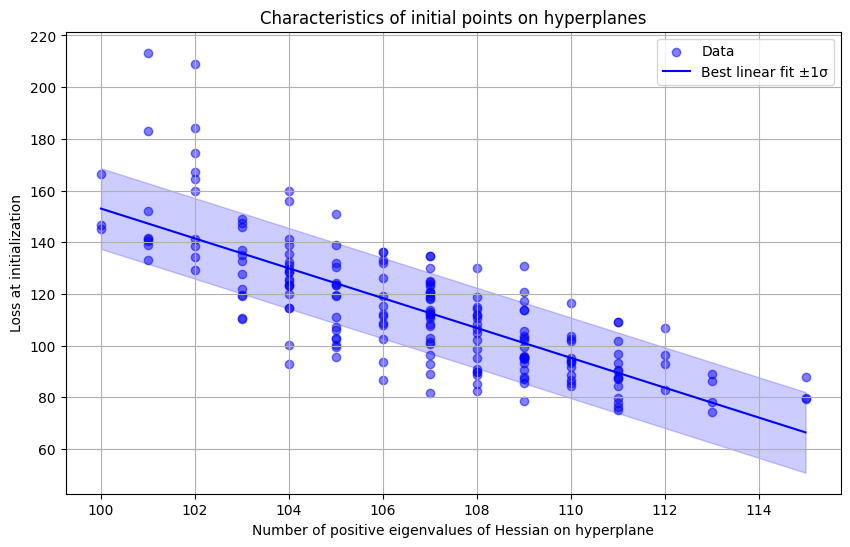

In [24]:
#@title View results from the saved file

path_result = f"{args.save_dir}/data.pkl"
with open(path_result, "rb") as f:
    result = pickle.load(f)

pos_eigenvalues_list = result['pos_eigenvalues_list']
loss_list = result['loss_list']

plot_loss_positive_correlation(pos_eigenvalues_list, loss_list)

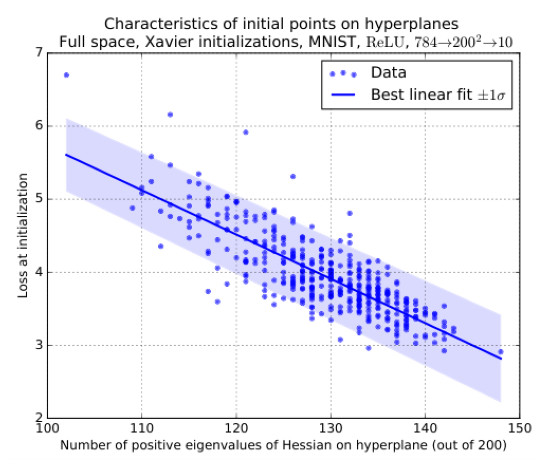

In [25]:
#@title Comparaison with paper's [1] figures
pdf_path = f'{input_path}/Figures [1]/loss_positive_correlation.pdf'

pdf_document = fitz.open(pdf_path)
page = pdf_document.load_page(0)
pix = page.get_pixmap()
img = Image.open(io.BytesIO(pix.tobytes("png")))  # Convertir en image PIL
pdf_document.close()

plt.imshow(img)
plt.axis('off')  # Cacher les axes

plt.tight_layout()
plt.show()

#### **Observations**  

Our results show a similar trend to the findings in [1], reinforcing the hypothesis that a lower initial loss correlates with a higher fraction of positive curvature directions.  

This experiment provides insight into the impact of initialization on the geometry of the loss landscape, reinforcing the importance of selecting an appropriate initialization radius.

---
# Third Experiment : *Validation Accuracy on Hyperplanes*

In this final experiment, we investigate how training on different hyperplanes impacts the **final validation accuracy**. Our approach involves:  

1. **Early Stopping Step Estimation:**  
   - Before training, we determine an approximate step for early stopping based on the loss evolution.  
   - This ensures that all models are trained under comparable conditions.  

2. **Training Models on Hyperplanes:**  
   - We train models constrained to different hyperplanes, using the **Adam optimizer**.  
   - The initialization radius is varied to study its effect on performance.  

3. **Results Visualization on a 2D Grid:**  
   - We plot **validation accuracy (y-axis)** against the **initialization radius (x-axis)**.  
   - This allows us to observe how initialization affects final model performance.  

In [26]:
#@title Setting experiment parameters

@dataclass
class ValidationAccuracyExperimentArgs(BaseExperimentArgs):
    num_steps: int = 7_000
    log_scale_min_max: tuple = (-2, 2)
    dimension_min_max: tuple = (0, 500)
    num_points: int = 10
    max_steps: int = 10_000
    patience: int = 1_000
    log_scale: float = 0.0
    dimension: int = 200
    save_dir: str = f"{input_path}/results/Validation accuracy on hyperplanes"


    def validate(self):
        """ Ensure consistency of experiment settings """
        default_save_dir = f"{input_path}/results/Validation accuracy on hyperplanes"
        if self.save_dir == default_save_dir and (
            self.model_class != ScaledNN
            or self.hyperplane_opt_class != HyperplaneOptimizer
            or not isinstance(self.criterion, nn.CrossEntropyLoss)
            or self.layer_sizes != [28*28, 200, 200, 10]
            or self.log_scale_min_max != (-2, 2)
            or self.dimension_min_max != (0, 500)
        ):
            raise ValueError("For further experiments, please change the `save_dir` path.")

args = ValidationAccuracyExperimentArgs()
args.validate()  # Ensure settings are consistent

for arg in args.__dict__:
    print(f"{arg}: {getattr(args, arg)}")


model_class: <class '__main__.ScaledNN'>
hyperplane_opt_class: <class '__main__.HyperplaneOptimizer'>
criterion: CrossEntropyLoss()
layer_sizes: [784, 200, 200, 10]
num_steps: 7000
log_scale_min_max: (-2, 2)
dimension_min_max: (0, 500)
num_points: 10
max_steps: 10000
patience: 1000
log_scale: 0.0
dimension: 200
save_dir: /content/gdrive/MyDrive/Polytechnique Mtl/Deep learning dynamics/The goldilocks zone /results/Validation accuracy on hyperplanes


## Determining the Optimal Number of Training Steps for Model Convergence

In [27]:
#@title `find_early_stopping_steps` function
def find_early_stopping_steps(model_class, hyperplane_opt_class, x_train, y_train, x_test, y_test,
                              layer_sizes, log_scale, dimension, max_steps=100, patience=5):

    # Initialize model and hyperplane optimizer
    model = model_class(layer_sizes, log_scale).to(device)
    D = compute_total_parameters(args.layer_sizes)

    hyperplane_opt = hyperplane_opt_class(model, D, dimension, device)

    optimizer = torch.optim.Adam([hyperplane_opt.theta], lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # For tracking validation performance
    best_val_acc = 0.0
    best_step = 0
    no_improvement = 0

    validation_history = []

    for step in tqdm(range(max_steps)):
        # Training phase
        model.train()
        optimizer.zero_grad()

        hyperplane_opt.update_model_params(model)
        outputs = model(x_train.view(-1, 28*28))
        loss = criterion(outputs, y_train)

        loss.backward()
        full_grad = torch.cat([p.grad.view(-1) for p in model.parameters()])
        projected_grad = hyperplane_opt.project_gradient(full_grad)
        hyperplane_opt.theta.grad = projected_grad

        optimizer.step()

        # Validation phase
        model.eval()
        with torch.no_grad():
            outputs = model(x_test.view(-1, 28*28))
            _, predicted = torch.max(outputs.data, 1)
            val_acc = (predicted == y_test).sum().item() / y_test.size(0)

        validation_history.append(val_acc)
        #print(f'Epoch {step+1}, Loss: {loss.item():.4f}, Validation Accuracy: {val_acc:.4f}')

        # Check if we have an improvement
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_step = step
            no_improvement = 0
        else:
            no_improvement += 1

        # Early stopping check
        if no_improvement >= patience:
            print(f"Early stopping triggered after {step+1} steps")
            break

    print(f"Best validation accuracy: {best_val_acc:.4f} at step {best_step+1}")

    # Plot the validation accuracy curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(validation_history)+1), validation_history)
    plt.axvline(x=best_step+1, color='r', linestyle='--',
                label=f'Best step: {best_step+1}')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy vs Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_step + 1, best_val_acc

 82%|████████▏ | 8184/10000 [03:17<00:43, 41.40it/s]


Early stopping triggered after 8185 epochs
Best validation accuracy: 0.5801 at epoch 7185


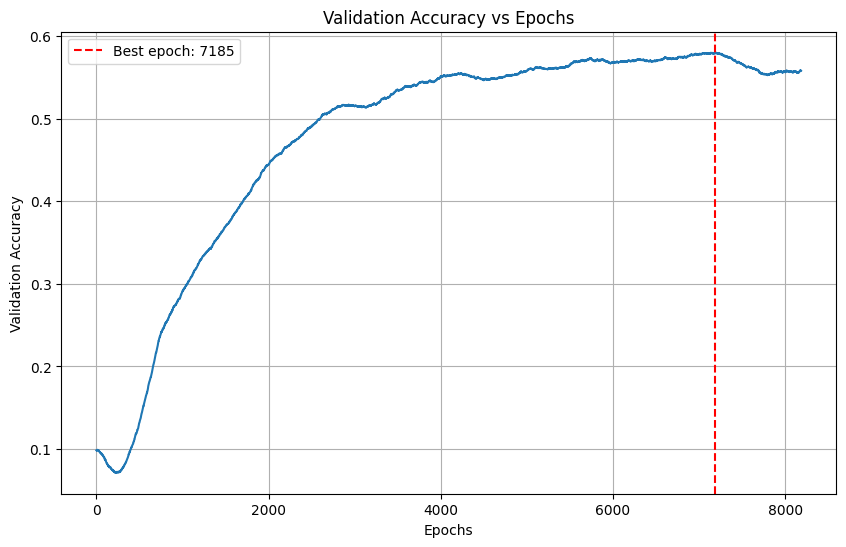

Recommended number of epochs for early stopping: 7185


In [ ]:
#@title Calling `find_early_stopping_steps` to Determine Training Steps
optimal_steps, _ = find_early_stopping_steps(
    model_class=args.model_class,
    hyperplane_opt_class=args.hyperplane_opt_class,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    layer_sizes=args.layer_sizes,
    log_scale=args.log_scale,
    dimension=args.dimension,
    max_steps=args.max_steps,
    patience=args.patience
)

#7000
print(f"Recommended number of steps for early stopping: {optimal_steps}")

## Run, save, plot and compare the experiment

In [28]:
#@title Plotting function experiment *validation_acccuracy_hyperplane*
def plot_accuracy_heatmap(pickle_path, log_scale_min_max, dimension_min_max):
    # Load results
    with open(pickle_path, 'rb') as f:
        results = pickle.load(f)

    # Create grid for heatmap
    log_steps = np.arange(log_scale_min_max[0], log_scale_min_max[1], 0.5)  # Steps of 0.5
    dim_steps = np.arange(dimension_min_max[0], dimension_min_max[1], 100)  # Steps of 100

    # Initialize grid with empty lists to store accuracies
    grid = [[[] for _ in range(len(log_steps))] for _ in range(len(dim_steps))]

    # Fill grid with all accuracies for each cell
    for l, d, acc in results:
        l_idx = np.abs(log_steps - l).argmin()
        d_idx = np.abs(dim_steps - d).argmin()
        grid[d_idx][l_idx].append(acc)  # Append accuracy to the corresponding cell

    # Compute the mean accuracy for each cell
    mean_grid = np.full((len(dim_steps), len(log_steps)), np.nan)  # Initialize with NaN
    for d_idx in range(len(dim_steps)):
        for l_idx in range(len(log_steps)):
            if grid[d_idx][l_idx]:  # If the cell is not empty
                mean_grid[d_idx, l_idx] = np.mean(grid[d_idx][l_idx])  # Compute mean

    # Inverser l'ordre des lignes dans la matrice grid
    mean_grid = mean_grid[::-1]

    # Create heatmap
    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(mean_grid, cmap='Purples', cbar_kws={'label': 'Validation Accuracy after 7000 steps'},
                     vmin=0, vmax=1,
                     xticklabels=False,  # Désactiver les étiquettes x par défaut
                     yticklabels=False)  # Désactiver les étiquettes y par défaut


    # Ligne verticale pour l'initialisation Xavier
    ax.axvline(x=4, color='r', linestyle='--', alpha=0.5, label="Xavier")

    # Adjust x-axis ticks to start at -2 and align with the 0th index
    ax.set_xticks(np.arange(len(log_steps)))  # Set ticks at each grid cell
    ax.set_xticklabels([f'{x:.1f}' for x in log_steps])  # Label ticks with -2, -1.5, -1, ...

    # Adjust y-axis ticks to start at 0 and align with the 0th index
    ax.set_yticks(range(1,len(dim_steps)+1))  # Set ticks at each grid cell
    ax.set_yticklabels([f'{int(y)}' for y in dim_steps[::-1]])  # Label ticks with 0, 100, 200, ...

    plt.xlabel(r'$\log{10}(r^2/r^2_{xavier})$')
    plt.ylabel('Hyperplane dimension d')
    plt.title('Accuracies on hyperplanes')

    # Adjust tick labels
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)

    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(os.path.dirname(pickle_path), 'accuracy_heatmap.png'))
    plt.show()

In [29]:
#@title Training loop on hyperplane is defined
def training_loop(model, criterion, optimizer, hyperplane_opt, x_train, y_train, x_test, y_test, epochs=10000):
    best_val_acc = 0.0

    for epoch in range(epochs):
        # Training phase
        model.train()
        optimizer.zero_grad()

        # Mise à jour des paramètres du modèle
        hyperplane_opt.update_model_params(model)

        # Forward pass
        outputs = model(x_train.view(-1, 28*28))
        loss = criterion(outputs, y_train)

        # Backward pass avec projection du gradient
        loss.backward()

        # Projection du gradient dans le sous-espace
        full_grad = torch.cat([p.grad.view(-1) for p in model.parameters()])
        projected_grad = hyperplane_opt.project_gradient(full_grad)
        hyperplane_opt.theta.grad = projected_grad

        # Mise à jour des paramètres
        optimizer.step()

        # Validation phase
        model.eval()
        with torch.no_grad():
            outputs = model(x_test.view(-1, 28*28))
            _, predicted = torch.max(outputs.data, 1)
            total = y_test.size(0)
            correct = (predicted == y_test).sum().item()

        val_acc = correct / total
        if val_acc > best_val_acc:
            best_val_acc = val_acc

        #print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}, Validation Accuracy: {val_acc:.4f}')

    return best_val_acc

In [30]:
#@title Experiment's function : run and save the result in save_dir

def validation_accuracy_hyperplane(model_class, hyperplane_opt_class, x_train, y_train, x_test, y_test,
                                 logscale_min_max, dimension_min_max, num_points,
                                 layer_sizes, save_dir):

    pickle_path = os.path.join(save_dir, 'accuracy_results.pkl')

    # Load existing results if available
    if os.path.exists(pickle_path):
        with open(pickle_path, 'rb') as f:
            results = pickle.load(f)
    else:
        results = []

    criterion = nn.CrossEntropyLoss()

    for point in tqdm(range(num_points)):
        # Generate random hyperparameters
        l = np.random.uniform(logscale_min_max[0], logscale_min_max[1])
        d = np.random.randint(dimension_min_max[0], dimension_min_max[1] + 1)

        # Initialize model and hyperplane optimizer
        model = model_class(layer_sizes, l).to(device)
        D = compute_total_parameters(args.layer_sizes)
        hyperplane_opt = hyperplane_opt_class(model, D, d, device)

        # Create optimizer
        optimizer = torch.optim.Adam([hyperplane_opt.theta], lr=0.001)

        # Train and validate using your training loop
        best_val_acc = training_loop(
            model=model,
            criterion=criterion,
            optimizer=optimizer,
            hyperplane_opt=hyperplane_opt,
            x_train=x_train,
            y_train=y_train,
            x_test=x_test,
            y_test=y_test,
            epochs=7_000
        )

        # Store results
        results.append((l, d, best_val_acc))

        # Save results after each point
        with open(pickle_path, 'wb') as f:
            pickle.dump(results, f)

    return results

In [ ]:
#@title Call the experiment's function
results = validation_accuracy_hyperplane(
    model_class=args.model_class,
    hyperplane_opt_class=args.hyperplane_opt_class,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    logscale_min_max=args.log_scale_min_max,
    dimension_min_max=args.dimension_min_max,
    num_points=args.num_points,
    layer_sizes=args.layer_sizes,
    save_dir=args.save_dir
)

100%|██████████| 1/1 [02:46<00:00, 166.68s/it]


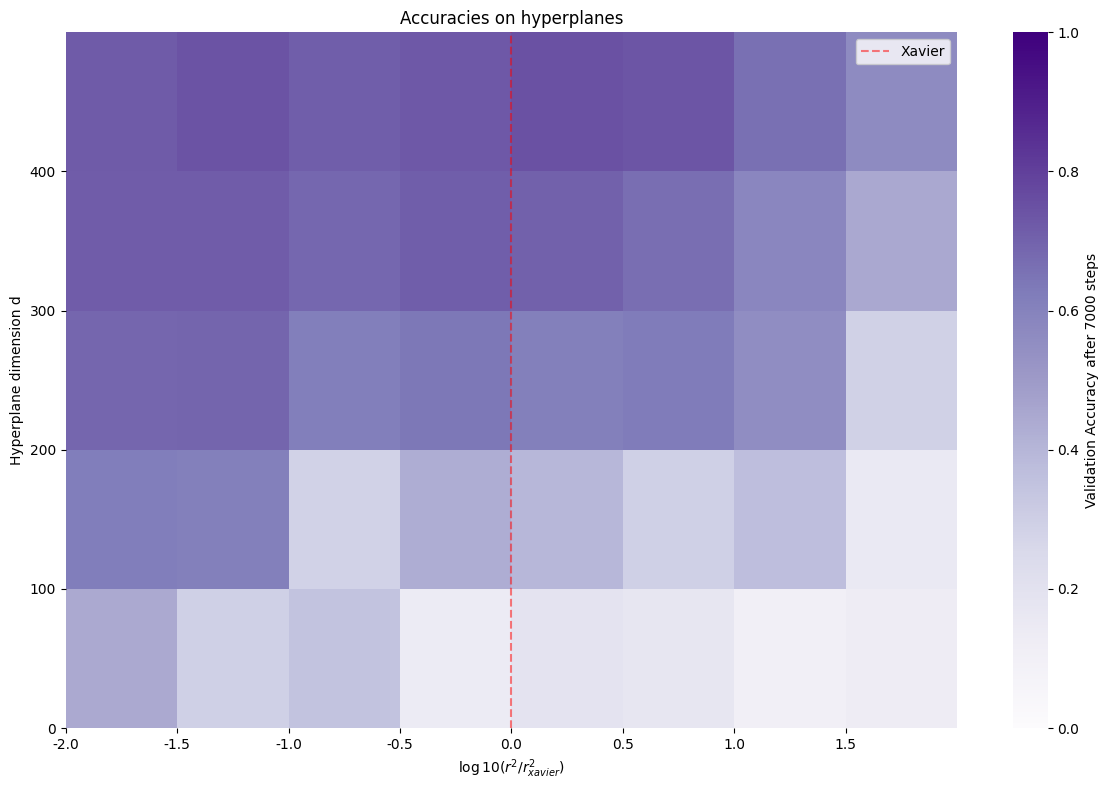

In [31]:
#@title View results from the saved file
pickle_path = os.path.join(args.save_dir, 'accuracy_results.pkl')
plot_accuracy_heatmap(pickle_path, args.log_scale_min_max, args.dimension_min_max)

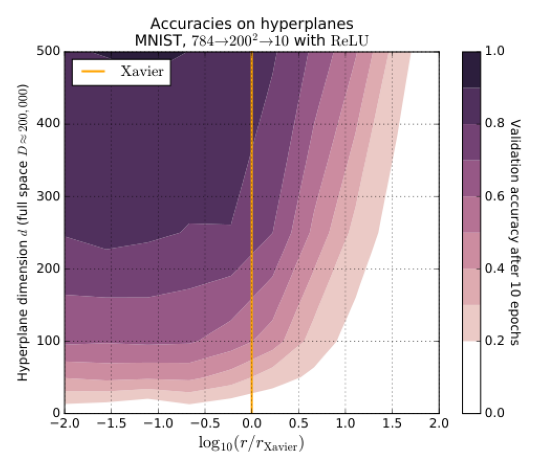

In [32]:
#@title Comparaison with paper's [1] figures
pdf_path = f'{input_path}/Figures [1]/radius_dim_plane_acc1.pdf'

pdf_document = fitz.open(pdf_path)
page = pdf_document.load_page(0)
pix = page.get_pixmap()
img = Image.open(io.BytesIO(pix.tobytes("png")))  # Convertir en image PIL
pdf_document.close()

plt.imshow(img)
plt.axis('off')  # Cacher les axes

plt.tight_layout()
plt.show()

### **Observations**  

Our experiment on training models within hyperplanes and analyzing validation accuracy provides results that align with those presented in [1]. Despite using a **more approximate grid** due to fewer training runs, the overall trends remain consistent with the paper.  

- **Key Observation:**  
  - In the **top-left region** of the grid (**high-dimensional hypersphere with a lower norm than Xavier initialization**), we observe **better accuracy**, confirming the findings in [1].  
  - This suggests that specific initialization choices lead to improved generalization performance.  

While our grid resolution is coarser, the results support the hypothesis that initialization plays a critical role in optimization and final model accuracy.

---
# Comprehensive Conclusion of the Three Experiments

Through the course of our three experiments, we have examined crucial aspects of neural network initialization, focusing on how the choice of initialization impacts the model's behavior and its performance. The experiments were designed to delve into the concept of the **Goldilocks zone** in initialization, investigate the correlation between **initialization loss** and **positive curvature**, and analyze how **validation accuracy** varies with initialization settings when training on hyperplanes. Below is a detailed summary of the findings from each experiment and the overarching insights derived from the results.

#### **1) Goldilocks Zone at Initialization Focus (Positive Curvature)**

The first experiment centered around exploring the **Goldilocks zone** at initialization by examining the fraction of **positive curvature** as a function of the radius of initialization. In this experiment, we rescaled the Xavier initialization radius and analyzed how this rescaling affected the positive curvature observed at the beginning of training. The main finding was the clear existence of the **Goldilocks zone**, a region where the positive curvature is maximized, offering an optimal condition for the model's initial behavior. This optimal curvature leads to a well-conditioned optimization landscape, where the model begins training in a favorable region of the parameter space.

#### **2) Correlation Between Initialization Loss and Positive Curvature**

In our second experiment, we shifted our focus to the correlation between the **initialization loss** and the **positive curvature** of the Hessian. This experiment aimed to investigate whether a higher initial loss, which **could** corresponds to a more challenging starting point in training, correlates with the amount of positive curvature in the parameter space at initialization.

We observed a strong correlation between initialization loss and positive curvature highlighting that initialization can have a significant impact not only on the curvature of the objective surface but also on the early dynamics of optimization. A **maybe** more favorable initialization (low loss, high positive curvature) **could** leads to a better starting point for optimization, allowing the model to escape poor local minima and settle into flatter regions of the parameter space that facilitate faster convergence.

#### **3) Final Accuracy in Xavier Initialization on Hyperplane**

The third experiment extended the analysis to the **final accuracy** of models trained on **hyperplanes**. The aim was to observe how the **radius of initialization** and the **dimension of hyperplanes** influence the final validation accuracy after training, specifically comparing the behavior of models initialized with Xavier's scheme on hyperplanes. In this experiment, we varied the radius of the initial weights and the dimension of hyperplanes on a 2D grid and tracked the validation accuracy after a fixed number of training steps, with the optimizer being Adam.

The results here were also insightful and mostly aligned with the paper's findings, although the grid was somewhat more approximate due to fewer training steps being performed. Still, we observed that models initialized with a **lower norm** than Xavier's initialization in the **top-left corner of the grid** (representing high-dimensional hyperspheres and smaller initialization radii) consistently achieved better **final validation accuracy**. This aligns with the conclusion in [1] that a better match between the geometry of the initialization and the optimization landscape leads to improved performance. Specifically, these results emphasize that a well-chosen initialization not only affects the curvature but also plays a crucial role in the model's ability to achieve high final accuracy.

#### **Overall Insights and Implications**

When considered together, these three experiments provide a compelling narrative about the role of initialization in deep learning models. First, they confirm the existence of the **Goldilocks zone**, where initialization leads to optimal positive curvature, a region that seems to be particularly beneficial for model convergence. Second, the strong correlation between **initialization loss** and **positive curvature** reinforces the link beetween initialization loss and the Goldilocks zone. Finally, the validation accuracy experiments show that an appropriate initialization, particularly one with a lower radius than Xavier’s norm, leads to improved model performance on hyperplanes, further validating the importance of initialization in the broader context of model training.

---
# Analysis of the Goldilocks Zone: A Re-evaluation

In the previous section, we explored the Goldilocks zone of neural network initialization as presented in [1]. However, a more recent study, "Deconstructing the Goldilocks Zone of Neural Network Initialization" [2], critically examines this concept and challenges some of its fundamental assumptions.

The authors of [2] argue that the high positive curvature and local convexity of the loss Hessian, which were previously associated with highly trainable initialization points, are not necessarily indicative of better model performance. Their study demonstrates that the positive curvature of the training loss primarily results from the dominant eigenspace of the Hessian's positive semi-definite component (the G-term) rather than a particular initialization norm. Moreover, they find that strong model performance is not strictly aligned with the Goldilocks zone, as certain networks exhibit degenerate behaviors even within this region.

To further investigate these claims, we will replicate some of the experiments conducted in [2] using their provided codebase. Our goal is to gain deeper insights into the practical relevance of the Goldilocks zone in neural network initialization.



In [33]:
#@title Set up and requirements

os.chdir(f"{input_path}/Deconstructing the Goldilocks Zone")
hessian_directory = os.path.join(os.getcwd(), "src/hessian-eigenthings")
# Ajouter le répertoire hessian au chemin de recherche des modules
if hessian_directory not in sys.path:
    sys.path.insert(0, hessian_directory)

!pip install -r requirements.txt

Obtaining hessian-eigenthings from git+https://github.com/noahgolmant/pytorch-hessian-eigenthings.git@master#egg=hessian-eigenthings (from -r requirements.txt (line 8))
  Updating ./src/hessian-eigenthings clone (to revision master)
  Running command git fetch -q --tags
  Running command git reset --hard -q dce2e54a19963b0dfa41b93f531fb7742d46ea04
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.4 MB/s eta 0:00:00
  Running setup.py develop for hessian-eigenthings


In [34]:
from linalg import *
from misc import *
from models import *
from models.utils import get_layer_idxs
from evaluate import *
from data import *
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams["figure.figsize"] = (6.5,4.5)
font = {'family': 'sans-serif','size': 18}
mpl.rc('font', **font)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print(f'[device: {device} is ready]')

data = Circles(
    path='data/downloads',
    to_transform=False)

model = Demo(
    device=device,
    in_shape=data.in_shape,
    num_classes=data.num_classes,
    temperature=1,
    dtype=torch.float64,
    activation='ReLU')

w = get_trainable_parameters(model)
idxs = get_layer_idxs(model)
num_layers = len(idxs)

seeds = 3

[device: cpu is ready]


/content/gdrive/MyDrive/Polytechnique Mtl/Deep learning dynamics/The goldilocks zone /Deconstructing the Goldilocks Zone/data/circles.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

## Recreating the Goldilocks Zone

To analyze the Goldilocks zone, [2] explores its dependence on two key factors: the scale of initialization and the softmax temperature.  

Scaling the initialization refers to the transformation \( θ -> α θ \) with a positive scaling factor \( α \). This operation effectively rescales the parameter space, influencing the gradient norm and the variance of the logits. By carefully adjusting the softmax temperature \( T \) in proportion to the initialization scale \( (α^L) \), the model can preserve its training dynamics across different initialization magnitudes. This challenges the idea that the Goldilocks zone is solely determined by the initialization norm.  

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

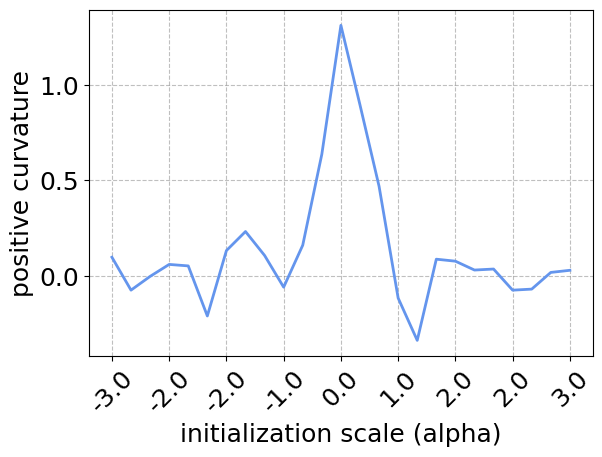

In [35]:
#@title By scaling the initialization

model.set_temperature(1.)
scales = 10**np.arange(-3,3.25,0.25)
curvs = np.zeros((seeds, len(scales)))

for seed in range(seeds):
    for scale_id in tqdm(range(len(scales))):
        set_trainable_parameters(model, scales[scale_id]*w)
        _, curv = goldilocks(model, data.datasets["train"], 50, device)
        curvs[seed][scale_id] = curv

plt.plot(curvs.mean(0), color='cornflowerblue', linewidth=2)
plt.xticks(
        range(len(scales))[::3],
        [round(np.log10(scale),0) for scale in scales][::3],
        rotation=45)
plt.xlabel('initialization scale (alpha)')
plt.ylabel('positive curvature')
plt.grid(ls='dashed', color='grey', alpha=0.5)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

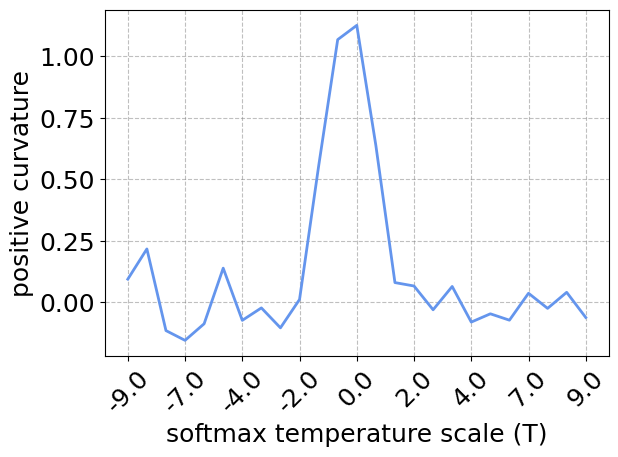

In [36]:
#@title By scaling the softmax temperature

set_trainable_parameters(model, w)
temps = 10**np.arange(-3*num_layers,3*num_layers+0.25*num_layers,0.25*num_layers)
curvs = np.zeros((seeds, len(scales)))

for seed in range(seeds):
    for temp_id in tqdm(range(len(temps))):
        model.set_temperature(temps[temp_id])
        _, curv = goldilocks(model, data.datasets["train"], 50, device)
        curvs[seed][temp_id] = curv

plt.plot(curvs.mean(0), color='cornflowerblue', linewidth=2)
plt.xticks(
        range(len(temps))[::3],
        [round(np.log10(temp),0) for temp in temps][::3],
        rotation=45)
plt.xlabel('softmax temperature scale (T)')
plt.ylabel('positive curvature')
plt.grid(ls='dashed', color='grey', alpha=0.5)

The experiments in [2] show that varying either the initialization scale or the softmax temperature leads to a peak in the positive curvature of the Hessian. Specifically, when scaling the initialization, the positive curvature exhibits a distinct maximum at an intermediate scale. Similarly, when varying the softmax temperature, a peak emerges at a critical value (corresponding to an (α)-scaling factor of 1). These observations indicate that both factors play a role in defining the Goldilocks zone, rather than the initialization norm alone.  

## Gauss-Newton decomposition & spectral norm  

In this experiment, we analyze the Gauss-Newton decomposition of the Hessian and its relation to the spectral norm. The decomposition provides insight into the curvature of the loss landscape, which is essential for understanding the Goldilocks zone.  

In [37]:
model.set_temperature(1.)
scales = 10**np.arange(-3,3,0.25)
R = get_random_ortho_matrix(w.numel(), 50, device).to(model.dtype)
curvs = {
    'G': np.zeros((seeds, len(scales))),
    'H': np.zeros((seeds, len(scales))),
    'Hessian': np.zeros((seeds, len(scales)))}
norms = {
    'G': np.zeros((seeds, len(scales))),
    'H': np.zeros((seeds, len(scales))),
    'Hessian': np.zeros((seeds, len(scales)))}

for seed in range(seeds):
    for scale_id in tqdm(range(len(scales))):
        set_trainable_parameters(model, scales[scale_id]*w)
        J = get_Jacobian(model, data.datasets["train"], data.num_classes, R)
        p = F.softmax(model.predict(data.datasets["train"]), dim=-1).detach()
        G_term = get_G_term(J, p)
        L_G = torch.real(torch.linalg.eig(G_term)[0])
        curvs['G'][seed][scale_id] = L_G.sum()/L_G.norm() if L_G.norm()>0 else 0
        norms['G'][seed][scale_id] = L_G.max()
        Hessian = hessian(model, data.datasets["train"], True, R)
        L_Hessian = torch.real(torch.linalg.eig(Hessian)[0])
        curvs['Hessian'][seed][scale_id] = L_Hessian.sum()/L_Hessian.norm()
        norms['Hessian'][seed][scale_id] = L_Hessian.max()
        H_term = Hessian - G_term
        L_H = torch.real(torch.linalg.eig(H_term)[0])
        curvs['H'][seed][scale_id] = L_H.sum()/L_H.norm()
        norms['H'][seed][scale_id] = L_H.max()

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

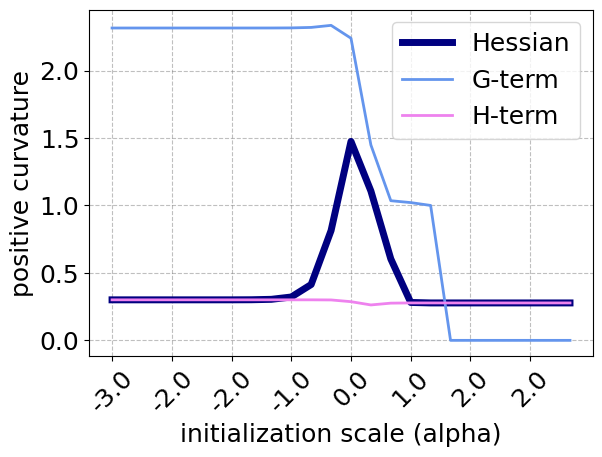

In [40]:
#@title Positive curvature of the G-term, H-term, and the Hessian

plt.plot(curvs['Hessian'].mean(0), color='navy', linewidth=5, label='Hessian')
plt.plot(curvs['G'].mean(0), color='cornflowerblue', linewidth=2, label='G-term')
plt.plot(curvs['H'].mean(0), color='violet', linewidth=2, label='H-term')
plt.xticks(
        range(len(scales))[::3],
        [round(np.log10(scale),0) for scale in scales][::3],
        rotation=45)
plt.xlabel('initialization scale (alpha)')
plt.ylabel('positive curvature')
plt.grid(ls='dashed', color='grey', alpha=0.5)
plt.legend()

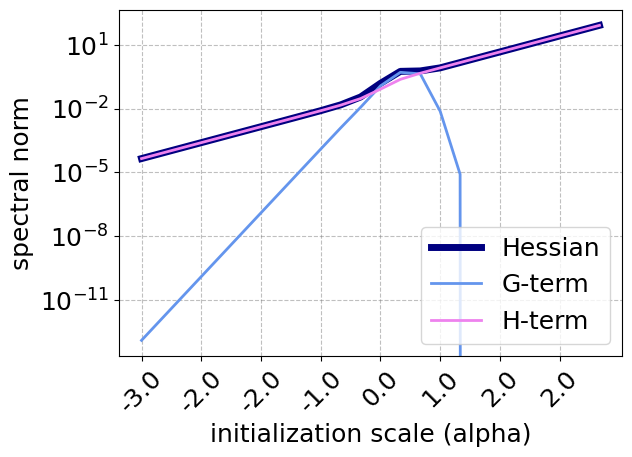

In [39]:
#@title Spectral norm of the G-term, H-term, and the Hessian

plt.plot(norms['Hessian'].mean(0), color='navy', linewidth=5, label='Hessian')
plt.plot(norms['G'].mean(0), color='cornflowerblue', linewidth=2, label='G-term')
plt.plot(norms['H'].mean(0), color='violet', linewidth=2, label='H-term')
plt.xticks(
        range(len(scales))[::3],
        [round(np.log10(scale),0) for scale in scales][::3],
        rotation=45)
plt.xlabel('initialization scale (alpha)')
plt.ylabel('spectral norm')
plt.grid(ls='dashed', color='grey', alpha=0.5)
plt.legend()
plt.yscale('log')

The first graph displays the positive curvature as a function of the scaling factor \( α \). The decomposition into three terms—Hessian, G-term, and H-term—reveals that the peak of the Goldilocks zone is primarily driven by the G-term. This supports the claim from [2] that the G-term is the dominant contributor to positive curvature in this regime.  

The Gauss-Newton decomposition highlights a bulk-outlier structure in the Hessian spectrum, where the majority of eigenvalues are small, while a few large positive outliers emerge. The outliers are attributed to the G-term, whereas the H-term contributes primarily to the bulk eigenvalues. This structure is key to understanding the transition between trainable and degenerate initialization regimes.  

An important observation (Spectral norm figure) is that the necessary and sufficient condition for the Goldilocks zone is given by:  

|| G'\* || > || H'\* ||


This means that when the spectral norm of the G-term dominates that of the H-term, the Hessian exhibits strong positive curvature. The experiment confirms that this inequality holds around \( α = 1 \), where the G-term maintains an edge over the H-term, leading to enhanced trainability.  

For large \( α \), the logit variance increases, causing the softmax outputs to collapse into one-hot distributions. This results in the vanishing of the G-term, leaving only the H-term to govern the Hessian, leading to a loss of positive curvature. Conversely, for small \( α \), the G-term still contributes significantly but decays at a faster rate than the H-term. This aligns with the vanishing logit gradient phenomenon, where the loss gradient can approach zero while maintaining high positive curvature.  

These findings reinforce the idea that the Goldilocks zone is defined by the interplay between the G-term and H-term rather than initialization scale alone.

### Expected G-term

In the third experiment, the paper examines the **expected G-term**, which relates to the curvature of the loss landscape in neural networks. The figure specifically compares the **true G-term** (G\*) and its **expected version** (E[G\*]), computed across different initialization scales. These scales influence the model's confidence—how strongly its predictions favor certain outputs.  

When weights are multiplied by (α), this directly affects the magnitude of logits before applying softmax. For small \(α\), the logits remain close to zero, leading to a **nearly uniform output distribution** (low confidence). As \(α\) increases, the logits become larger, resulting in **sharper predictions** with higher confidence.  

The results suggest a connection between **positive curvature** and model confidence. When confidence is low, curvature tends to be higher. This is important because curvature influences gradient updates—higher curvature can lead to smaller updates, potentially slowing down learning.  

Additionally, the paper presents a theoretical approximation for the expected G-term's curvature, which aligns well with empirical observations. This suggests that the theoretical model effectively captures key aspects of how initialization impacts training dynamics.

In [14]:
model.set_temperature(1.)
scales = 10**np.arange(-3,3,0.25)
curvs_G = np.zeros((seeds, len(scales)))
curvs_EG = np.zeros((seeds, len(scales)))
R = get_random_ortho_matrix(w.numel(), 50, device).to(model.dtype)

for seed in range(seeds):
    for scale_id in tqdm(range(len(scales))):
        set_trainable_parameters(model, scales[scale_id]*w)
        J = get_Jacobian(model, data.datasets["train"], data.num_classes, R)
        p = F.softmax(model.predict(data.datasets["train"]), dim=-1).detach()
        var_C = (J.mean(0).std([0,1]))**2
        cs = J.mean(0, keepdim=True)
        cs = cs.repeat(J.shape[0],1,1)
        var_E = ((J-cs).std([0,1,2]))**2
        G_term = get_G_term(J, p)
        L_G = torch.real(torch.linalg.eig(G_term)[0])
        curvs_G[seed][scale_id] = L_G.sum()/L_G.norm() if L_G.norm()>0 else 0
        curvs_EG[seed][scale_id] = EG_curvature(var_E, var_C, R.shape[0], p)

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

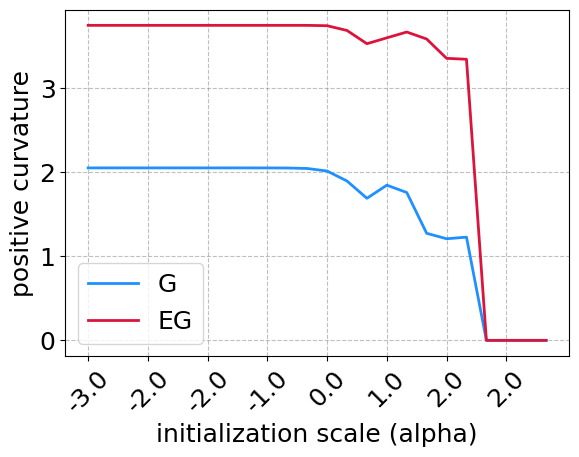

In [15]:
#@title Positive curvature of the empirical G-term and the expected G-term

plt.plot(curvs_G.mean(0), color='dodgerblue', linewidth=2, label='G')
plt.plot(curvs_EG.mean(0), color='crimson', linewidth=2, label='EG')
plt.xticks(
        range(len(scales))[::3],
        [round(np.log10(scale),0) for scale in scales][::3],
        rotation=45)
plt.xlabel('initialization scale (alpha)')
plt.ylabel('positive curvature')
plt.grid(ls='dashed', color='grey', alpha=0.5)
plt.legend()

### Expected gradient & more

In [16]:
num_samples = 500
model.set_temperature(1.)
set_trainable_parameters(model, w)

R = get_random_ortho_matrix(w.numel(), 50, device).to(model.dtype)
J = get_Jacobian(model, data.datasets["train"], data.num_classes, R)
var_C = (J.mean(0).std([0,1]))**2
Q = get_prior(data.datasets["train"].targets, data.num_classes)

g_norms = np.zeros((num_samples,))
prior_dist = np.zeros((num_samples,))
losses = np.zeros((num_samples,))
avg_entropy = np.zeros((num_samples,))
curvs = np.zeros((num_samples,))

for i in tqdm(range(num_samples)):
    model.zero_grad()
    model.initialize()
    out = model.predict(data.datasets["train"])
    p = F.softmax(out, dim=-1).detach().cpu()
    avg_entropy[i] = Categorical(p).entropy().mean(0)
    loss = F.cross_entropy(out, data.datasets["train"].targets.to(device))
    loss.backward()
    losses[i] = loss.item()
    g = get_current_gradients(model).detach()
    g_norms[i] = g.norm()
    prior_dist[i] = (Q-p.mean(0)).norm()
    curv = goldilocks(model, data.datasets["train"], 50, device)[1]
    curvs[i] = curv

  0%|          | 0/500 [00:00<?, ?it/s]

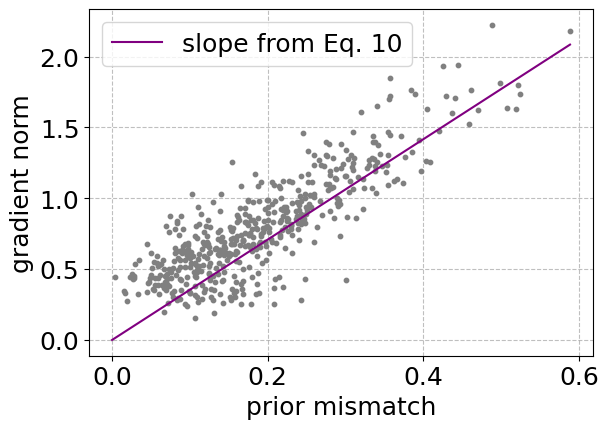

In [17]:
#@title Gradient norms vs. prior mismatch

plt.scatter(prior_dist, g_norms, s=10, color='grey')
plt.plot([0,prior_dist.max()],[0, R.shape[1]*np.sqrt(var_C)*prior_dist.max()], color='purple', label='slope from Eq. 10')
plt.xlabel('prior mismatch')
plt.ylabel('gradient norm')
plt.grid(ls='dashed', color='grey', alpha=0.5)
plt.legend()

In this figure, we analyze the relationship between the gradient norm and the prior mismatch, which measures the difference between the dataset's class prior Q and the model's average softmax output Q_hat. By computing gradients on a randomly initialized model, we observe that as the prior mismatch increases, the gradient norm follows a linear trend predicted by the theoretical variance of the Jacobian. This confirms that when the model's softmax predictions align poorly with the true data distribution, the gradients tend to be stronger, providing a mechanism for guiding the model's updates during training. This result also aligns with findings from Fort & Ganguli [1], which suggest that randomly initialized models exhibit biased priors, leading to a systematic dependence between gradient norms and prior mismatch.

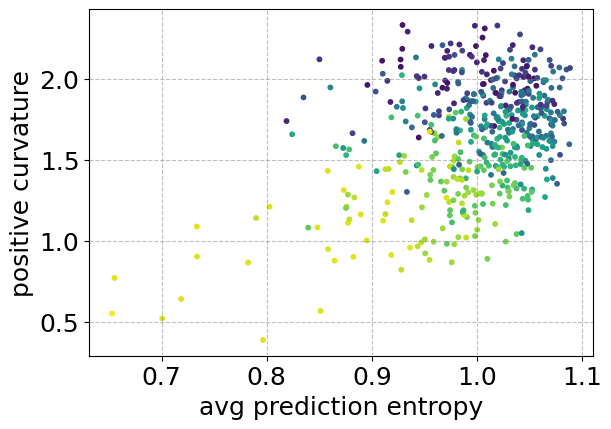

In [18]:
#@title The inteplay between output entropy, positive curvature, and initial loss

bins = [np.quantile(losses, i) for i in np.linspace(0,1,20)]
idxs = np.digitize(losses, bins)
cmap = plt.get_cmap('viridis')
colors = np.array([cmap(i) for i in np.linspace(0,1,len(bins)+1)])
plt.scatter(avg_entropy, curvs, s=10, color=colors[idxs])
plt.xlabel('avg prediction entropy')
plt.ylabel('positive curvature')
plt.grid(ls='dashed', color='grey', alpha=0.5)

We explore here the interplay between model confidence (as measured by the entropy of the softmax output), the curvature of the loss landscape, and the initial loss value. By computing these metrics over multiple random initializations, you observe that models with higher entropy predictions—meaning they are less confident—tend to have higher positive curvature and lower initial loss. This relationship follows from Jensen's inequality, which shows that low-confidence models have a lower bound on their expected loss. Furthermore, Fort & Scherlis [1] noted that positive curvature is a desirable property for learning, as it helps stabilize optimization. The result reinforce these observations, showing that initializations leading to higher curvature and lower loss tend to correspond to models with more uncertain predictions, providing insight into how initialization affects early training dynamics.

## Top Hessian eigenvector before softmax collapse

In this experiment, the goal is to analyze how the dominant eigenvector of the Hessian matrix evolves with different initialization scales before the softmax predictions collapse. The LeNet-300-100 model is trained on the FashionMNIST dataset with various scaling factors applied to its initial parameters. For each scale, the top eigenvector of the Hessian is computed using the eigenthings method, and its structure is visualized. The images generated correspond to the first layer's weight perturbations averaged along the dominant eigenvector, providing insights into which features the model is most sensitive to at initialization.

In [19]:
data = FMNIST(
    path='data/downloads',
    to_transform=False)

model = LeNet300100(
    device=device,
    in_shape=data.in_shape,
    num_classes=data.num_classes,
    temperature=1,
    dtype=torch.float64,
    activation='ReLU')

w = get_trainable_parameters(model)

  0%|          | 0/6 [00:00<?, ?it/s]

 [=============================================================>...]  Step: 25s252ms | Tot: 7m5s | power iter error: 0.0047 20/20 
 [=============================================================>...]  Step: 22s395ms | Tot: 6m57s | power iter error: 0.0008 20/20 
 [=============================================================>...]  Step: 22s770ms | Tot: 6m59s | power iter error: 0.0120 20/20 


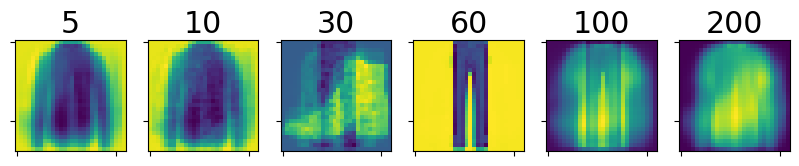

In [20]:
scales = [5, 10, 30, 60, 100, 200]
fig, axes = plt.subplots(ncols=len(scales), nrows=1, figsize=(10,2))
for scale_id in tqdm(range(len(scales))):
    set_trainable_parameters(model, scales[scale_id]*w)
    _, V = eigenthings(
            model=model,
            loss=F.cross_entropy,
            dataset=data.datasets["train"],
            num_things=1)
    img = V.squeeze()[:784*300].reshape(300,784)
    img = img.mean(axis=0).reshape(data.in_shape).squeeze()
    axes[scale_id].imshow(img, cmap='viridis')
    axes[scale_id].set_xticklabels(labels=[])
    axes[scale_id].set_yticklabels(labels=[])
    axes[scale_id].set_title(f'{scales[scale_id]}')

The results suggest that when the initialization scale is too large (α > 1), some weights grow disproportionately, leading to an increasing number of zero logits due to the ReLU activation. This phenomenon aligns with previous studies indicating that large-norm initializations tend to push networks into a lazy learning regime, where optimization dynamics become nearly linear. The results highlight that trainability is closely linked to initialization scale: models initialized within a specific range (the "Goldilocks zone") can successfully optimize, while others either collapse or fail to generalize. This experiment provides additional evidence that initialization scale plays a crucial role in determining the effective learning trajectory of deep networks.



# References

[1] [The Goldilocks zone: Towards better understanding of neural network loss  landscapes](https://arxiv.org/pdf/1807.02581)

[2] [Deconstructing the Goldilocks Zone of Neural Network Initialization](https://arxiv.org/pdf/2402.03579)

[3] [Hessian-based Analysis of Large Batch Training and Robustness to  Adversaries](https://arxiv.org/pdf/1802.08241)

[4] [ADAHESSIAN: An Adaptive Second Order Optimizer for Machine Learning](https://arxiv.org/pdf/2006.00719)

[5] [Understanding the difficulty of training deep feedforward neural networks](https://www.semanticscholar.org/paper/Understanding-the-difficulty-of-training-deep-Glorot-Bengio/ea9d2a2b4ce11aaf85136840c65f3bc9c03ab649)

[6] [Delving Deep into Rectifiers: Surpassing Human-Level Performance on  ImageNet Classification](https://arxiv.org/pdf/1502.01852)
